In [1]:
import copy
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss, MASE, mase_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# Load data

In [2]:
external_predictions = pd.read_csv('data/external_predictions.csv', index_col=0, parse_dates=True)
external_predictions

,forecast_PLN
2019-09-02 00:00:00,231.081699
2019-09-02 01:00:00,224.702813
2019-09-02 02:00:00,220.945387
2019-09-02 03:00:00,220.071567
2019-09-02 04:00:00,219.678348
...,...
2021-04-01 19:00:00,303.956955
2021-04-01 20:00:00,298.518453
2021-04-01 21:00:00,278.561916
2021-04-01 22:00:00,267.961446


In [3]:
def load_prices():
    raw_data = pd.read_csv('prices.csv')
    dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
    data = raw_data[['price']]
    data.index = dates
    data = data.sort_index()
    data.index.freq = 'H'
    return data
    
prices = load_prices()
index_copy = prices.index
prices = prices.merge(external_predictions, how='left', right_index=True, left_index=True)
prices.index = index_copy

prices

,price,forecast_PLN
delivery_start_utc,,
2010-01-01 00:00:00,129.30,NaN
2010-01-01 01:00:00,110.17,NaN
2010-01-01 02:00:00,104.46,NaN
2010-01-01 03:00:00,105.00,NaN
2010-01-01 04:00:00,105.01,NaN
...,...,...
2021-03-21 18:00:00,295.79,243.2430
2021-03-21 19:00:00,286.10,266.2044
2021-03-21 20:00:00,265.00,264.1716


In [4]:
years = [2018, 2019, 2020]
features_dict = dict()
data_dict = dict()
for year in years:
    features_dict[year] = pd.read_csv(f'data/features_{str(year)}.csv', index_col=0, parse_dates=True)
    data_dict[year] = prices[prices.index.year==year].merge(features_dict[year], how='left', right_index=True, left_index=True)
    
features = pd.concat(list(features_dict.values()), axis=0)
features

,weekday,month,co2_price_pln_actual,co2_price_eur_actual,load_forecast,capacity_jwcd_forecast,capacity_njwcd_forecast,generation_jwcd_forecast,generation_njwcd_forecast,generation_wind_forecast,...,Hard coal 500 available,Lignite 200 available,Lignite 300 available,Hard coal 300 available,Lignite 500 available,Lignite 1000 available,Biomass 200 available,Gas 200 available,HPS 100 available,HPS 200 available
2018-01-01 00:00:00,1,1,34.05,8.16,15175.0,22312.0,9327.0,6835.0,8340.0,3157.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 01:00:00,1,1,34.05,8.16,14600.0,22312.0,9272.0,6315.0,8285.0,3107.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 02:00:00,1,1,34.05,8.16,14025.0,22312.0,9263.0,5749.0,8276.0,3103.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 03:00:00,1,1,34.05,8.16,13625.0,22312.0,9296.0,5316.0,8309.0,3136.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 04:00:00,1,1,34.05,8.16,13400.0,22312.0,9402.0,4985.0,8415.0,3242.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,4,1,150.58,32.63,18675.0,24999.0,6902.0,12623.0,6052.0,422.0,...,1592.0,1944.0,4614.0,766.00,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 20:00:00,4,1,150.58,32.63,17550.0,24999.0,6881.0,11510.0,6040.0,399.0,...,1592.0,1874.0,4614.0,766.00,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 21:00:00,4,1,150.58,32.63,16675.0,24999.0,6837.0,10679.0,5996.0,372.0,...,1592.0,1864.0,4614.0,790.35,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 22:00:00,4,1,150.58,32.63,16250.0,24999.0,6779.0,10372.0,5878.0,354.0,...,1592.0,1864.0,4614.0,840.72,474.0,858.0,225.0,457.0,450.0,1256.0


In [5]:
data = pd.concat(list(data_dict.values()), axis=0)
data

,price,forecast_PLN,weekday,month,co2_price_pln_actual,co2_price_eur_actual,load_forecast,capacity_jwcd_forecast,capacity_njwcd_forecast,generation_jwcd_forecast,...,Hard coal 500 available,Lignite 200 available,Lignite 300 available,Hard coal 300 available,Lignite 500 available,Lignite 1000 available,Biomass 200 available,Gas 200 available,HPS 100 available,HPS 200 available
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,113.59,NaN,1,1,34.05,8.16,15175.0,22312.0,9327.0,6835.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 01:00:00,97.00,NaN,1,1,34.05,8.16,14600.0,22312.0,9272.0,6315.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 02:00:00,89.00,NaN,1,1,34.05,8.16,14025.0,22312.0,9263.0,5749.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 03:00:00,75.00,NaN,1,1,34.05,8.16,13625.0,22312.0,9296.0,5316.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-01 04:00:00,75.00,NaN,1,1,34.05,8.16,13400.0,22312.0,9402.0,4985.0,...,572.0,2127.0,4244.0,1532.00,954.0,858.0,225.0,457.0,450.0,1256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,239.50,225.613956,4,1,150.58,32.63,18675.0,24999.0,6902.0,12623.0,...,1592.0,1944.0,4614.0,766.00,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 20:00:00,227.00,220.507092,4,1,150.58,32.63,17550.0,24999.0,6881.0,11510.0,...,1592.0,1874.0,4614.0,766.00,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 21:00:00,229.75,207.238365,4,1,150.58,32.63,16675.0,24999.0,6837.0,10679.0,...,1592.0,1864.0,4614.0,790.35,474.0,858.0,225.0,457.0,450.0,1256.0


# Data lagging

In [6]:
def get_lags(df, cols, lags):
    df_copy = df.copy()
    for lag in lags:
        for col in cols:
            if col not in df.columns:
                print(f'Column {col} not found in given data frame columns')
                return df
            df_copy[f'{col}_lag_{lag}'] = df_copy[col].shift(lag)
    return df_copy

In [7]:
data.columns

Index(['price', 'forecast_PLN', 'weekday', 'month', 'co2_price_pln_actual',
       'co2_price_eur_actual', 'load_forecast', 'capacity_jwcd_forecast',
       'capacity_njwcd_forecast', 'generation_jwcd_forecast',
       'generation_njwcd_forecast', 'generation_wind_forecast',
       'generation_solar_forecast', 'reserve1_forecast', 'reserve2_forecast',
       'load_actual', 'generation_jwcd_actual', 'generation_pi_actual',
       'generation_irz_actual', 'generation_njwcd_actual',
       'crossborder_sync_balance_actual', 'crossborder_async_balance_actual',
       'CEPS_EXP', 'CEPS_IMP', 'SEPS_EXP', 'SEPS_IMP', '50HzT_EXP',
       '50HzT_IMP', 'SVK_EXP', 'SVK_IMP', 'UA_EXP', 'UA_IMP', 'LIT_EXP',
       'LIT_IMP', 'generation_wind_actual', 'generation_solar_actual',
       'Biomass 200 generation', 'Gas 200 generation', 'Gas 500 generation',
       'HPS 100 generation', 'HPS 200 generation', 'Hard coal 100 generation',
       'Hard coal 1000 generation', 'Hard coal 200 generation',
     

In [8]:
fixed_columns =  ['forecast_PLN', 'weekday', 'month']
columns_to_lag = [column for column in data.columns if column not in fixed_columns]
data_lagged = get_lags(df=data, cols=columns_to_lag, lags=[24, 7*24])
columns_to_drop = columns_to_lag
columns_to_drop.remove('price')
data_lagged = data_lagged.drop(columns_to_lag, axis=1).iloc[7*24:,]
data_lagged

,price,forecast_PLN,weekday,month,price_lag_24,co2_price_pln_actual_lag_24,co2_price_eur_actual_lag_24,load_forecast_lag_24,capacity_jwcd_forecast_lag_24,capacity_njwcd_forecast_lag_24,...,Hard coal 500 available_lag_168,Lignite 200 available_lag_168,Lignite 300 available_lag_168,Hard coal 300 available_lag_168,Lignite 500 available_lag_168,Lignite 1000 available_lag_168,Biomass 200 available_lag_168,Gas 200 available_lag_168,HPS 100 available_lag_168,HPS 200 available_lag_168
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,118.90,NaN,1,1,119.00,32.28,7.77,16125.0,20575.0,6648.0,...,572.0,2127.0,4244.0,1532.0,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-08 01:00:00,118.90,NaN,1,1,118.90,32.28,7.77,15450.0,20575.0,6686.0,...,572.0,2127.0,4244.0,1532.0,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-08 02:00:00,118.90,NaN,1,1,117.98,32.28,7.77,15100.0,20575.0,6763.0,...,572.0,2127.0,4244.0,1532.0,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-08 03:00:00,118.90,NaN,1,1,117.98,32.28,7.77,14925.0,20575.0,6861.0,...,572.0,2127.0,4244.0,1532.0,954.0,858.0,225.0,457.0,450.0,1256.0
2018-01-08 04:00:00,135.00,NaN,1,1,117.98,32.28,7.77,14925.0,20575.0,6922.0,...,572.0,2127.0,4244.0,1532.0,954.0,858.0,225.0,457.0,450.0,1256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,239.50,225.613956,4,1,244.58,145.47,32.13,22050.0,24333.0,7711.0,...,1532.0,2562.0,4614.0,1149.0,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 20:00:00,227.00,220.507092,4,1,216.48,145.47,32.13,21450.0,24333.0,7682.0,...,1532.0,2562.0,4614.0,1149.0,474.0,858.0,225.0,457.0,450.0,1256.0
2020-12-31 21:00:00,229.75,207.238365,4,1,215.00,145.47,32.13,20225.0,24333.0,7648.0,...,1532.0,2562.0,4614.0,1149.0,474.0,858.0,225.0,457.0,450.0,1256.0


# Auto-EDA

In [11]:
import sweetviz as sv

sweet_report = sv.analyze(data_lagged)
sweet_report.show_html('reports/EDA_sweetviz_data.html')
for year in years:
    sweet_report = sv.analyze(data_lagged[data_lagged.index.year==2018])
    sweet_report.show_html(f'reports/EDA_sweetviz_data_{str(year)}.html')

                                             |                                             | [  0%]   00:00 ->…

Report reports/EDA_sweetviz_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |                                             | [  0%]   00:00 ->…

Report reports/EDA_sweetviz_data_2018.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |                                             | [  0%]   00:00 ->…

Report reports/EDA_sweetviz_data_2019.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |                                             | [  0%]   00:00 ->…

Report reports/EDA_sweetviz_data_2020.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Simple models

In [69]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt

In [10]:
forecasts = data['forecast_PLN']
columns_to_drop = [
    'forecast_PLN', 
    'generation_solar_forecast_lag_24',
    'generation_solar_forecast_lag_168',
    'generation_solar_actual_lag_24',
    'generation_solar_actual_lag_168',
    'reserve2_forecast_lag_24',
    'reserve2_forecast_lag_168',
    'UA_EXP_lag_24',
    'UA_EXP_lag_168',
    'Biomass 200 available_lag_24',
    'Biomass 200 available_lag_168',
    'Gas 200 available_lag_24',
    'Gas 200 available_lag_168',
    'HPS 100 available_lag_24',
    'HPS 100 available_lag_168',
    'HPS 200 available_lag_24',
    'HPS 200 available_lag_168',
]
data_cleaned =data_lagged.drop(columns_to_drop, axis=1)
data_cleaned

,price,weekday,month,price_lag_24,co2_price_pln_actual_lag_24,co2_price_eur_actual_lag_24,load_forecast_lag_24,capacity_jwcd_forecast_lag_24,capacity_njwcd_forecast_lag_24,generation_jwcd_forecast_lag_24,...,Gas 500 available_lag_168,Hard coal 100 available_lag_168,Hard coal 1000 available_lag_168,Hard coal 200 available_lag_168,Hard coal 500 available_lag_168,Lignite 200 available_lag_168,Lignite 300 available_lag_168,Hard coal 300 available_lag_168,Lignite 500 available_lag_168,Lignite 1000 available_lag_168
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,118.90,1,1,119.00,32.28,7.77,16125.0,20575.0,6648.0,10485.0,...,447.0,155.0,2720.0,11469.0,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 01:00:00,118.90,1,1,118.90,32.28,7.77,15450.0,20575.0,6686.0,9772.0,...,447.0,155.0,2720.0,11469.0,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 02:00:00,118.90,1,1,117.98,32.28,7.77,15100.0,20575.0,6763.0,9345.0,...,447.0,155.0,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 03:00:00,118.90,1,1,117.98,32.28,7.77,14925.0,20575.0,6861.0,9072.0,...,447.0,155.0,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 04:00:00,135.00,1,1,117.98,32.28,7.77,14925.0,20575.0,6922.0,9014.0,...,447.0,155.0,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,239.50,4,1,244.58,145.47,32.13,22050.0,24333.0,7711.0,15114.0,...,953.0,200.0,2885.0,11263.5,1532.0,2562.0,4614.0,1149.0,474.0,858.0
2020-12-31 20:00:00,227.00,4,1,216.48,145.47,32.13,21450.0,24333.0,7682.0,14534.0,...,953.0,200.0,2885.0,11239.0,1532.0,2562.0,4614.0,1149.0,474.0,858.0
2020-12-31 21:00:00,229.75,4,1,215.00,145.47,32.13,20225.0,24333.0,7648.0,13343.0,...,953.0,200.0,2885.0,11219.0,1532.0,2562.0,4614.0,1149.0,474.0,858.0


In [11]:
missings = data_cleaned.isnull().sum()
missings[missings>0]

load_actual_lag_24                          4
generation_jwcd_actual_lag_24               4
generation_pi_actual_lag_24                 4
generation_irz_actual_lag_24                4
generation_njwcd_actual_lag_24              4
crossborder_sync_balance_actual_lag_24      4
crossborder_async_balance_actual_lag_24     4
generation_wind_actual_lag_24               6
load_actual_lag_168                         4
generation_jwcd_actual_lag_168              4
generation_pi_actual_lag_168                4
generation_irz_actual_lag_168               4
generation_njwcd_actual_lag_168             4
crossborder_sync_balance_actual_lag_168     4
crossborder_async_balance_actual_lag_168    4
generation_wind_actual_lag_168              6
dtype: int64

In [12]:
missing_columns = missings[missings>0].index
for missing_column in missing_columns:
    data_cleaned[missing_column] =data_cleaned[missing_column].fillna(data_cleaned[missing_column].median())

In [13]:
missings = data_cleaned.isnull().sum()
missings[missings>0]

Series([], dtype: int64)

In [14]:
X_train_full, y_train_full = data_cleaned.iloc[:,1:], data_cleaned.iloc[:,0]

In [15]:
VALIDATION_SIZE = 30*24

X_train, X_valid = X_train_full.iloc[:(-VALIDATION_SIZE), :], X_train_full.iloc[(-VALIDATION_SIZE):, :]
y_train, y_valid = y_train_full.iloc[:(-VALIDATION_SIZE)], y_train_full.iloc[(-VALIDATION_SIZE):]
X_train

,weekday,month,price_lag_24,co2_price_pln_actual_lag_24,co2_price_eur_actual_lag_24,load_forecast_lag_24,capacity_jwcd_forecast_lag_24,capacity_njwcd_forecast_lag_24,generation_jwcd_forecast_lag_24,generation_njwcd_forecast_lag_24,...,Gas 500 available_lag_168,Hard coal 100 available_lag_168,Hard coal 1000 available_lag_168,Hard coal 200 available_lag_168,Hard coal 500 available_lag_168,Lignite 200 available_lag_168,Lignite 300 available_lag_168,Hard coal 300 available_lag_168,Lignite 500 available_lag_168,Lignite 1000 available_lag_168
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,1,1,119.00,32.28,7.77,16125.0,20575.0,6648.0,10485.0,5640.0,...,447.0,155.0,2720.0,11469.00,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 01:00:00,1,1,118.90,32.28,7.77,15450.0,20575.0,6686.0,9772.0,5678.0,...,447.0,155.0,2720.0,11469.00,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 02:00:00,1,1,117.98,32.28,7.77,15100.0,20575.0,6763.0,9345.0,5755.0,...,447.0,155.0,2720.0,11329.00,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 03:00:00,1,1,117.98,32.28,7.77,14925.0,20575.0,6861.0,9072.0,5853.0,...,447.0,155.0,2720.0,11329.00,572.0,2127.0,4244.0,1532.0,954.0,858.0
2018-01-08 04:00:00,1,1,117.98,32.28,7.77,14925.0,20575.0,6922.0,9014.0,5911.0,...,447.0,155.0,2720.0,11329.00,572.0,2127.0,4244.0,1532.0,954.0,858.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01 19:00:00,2,12,260.60,130.25,29.09,24750.0,23248.0,7213.0,17971.0,6779.0,...,1378.0,200.0,2250.0,10278.00,1026.0,2197.5,3840.0,1149.0,474.0,858.0
2020-12-01 20:00:00,2,12,235.92,130.25,29.09,23900.0,23415.0,7270.0,17070.0,6830.0,...,1378.0,200.0,2250.0,10332.17,1026.0,2155.0,3840.0,1130.0,474.0,858.0
2020-12-01 21:00:00,2,12,259.10,130.25,29.09,22375.0,23415.0,7321.0,15511.0,6864.0,...,1378.0,200.0,2250.0,10381.32,1026.0,2155.0,3840.0,1021.0,474.0,858.0


In [16]:
y_train

delivery_start_utc
2018-01-08 00:00:00    118.90
2018-01-08 01:00:00    118.90
2018-01-08 02:00:00    118.90
2018-01-08 03:00:00    118.90
2018-01-08 04:00:00    135.00
                        ...  
2020-12-01 19:00:00    299.21
2020-12-01 20:00:00    247.00
2020-12-01 21:00:00    249.00
2020-12-01 22:00:00    234.42
2020-12-01 23:00:00    230.00
Freq: H, Name: price, Length: 25416, dtype: float64

In [17]:
X_valid

,weekday,month,price_lag_24,co2_price_pln_actual_lag_24,co2_price_eur_actual_lag_24,load_forecast_lag_24,capacity_jwcd_forecast_lag_24,capacity_njwcd_forecast_lag_24,generation_jwcd_forecast_lag_24,generation_njwcd_forecast_lag_24,...,Gas 500 available_lag_168,Hard coal 100 available_lag_168,Hard coal 1000 available_lag_168,Hard coal 200 available_lag_168,Hard coal 500 available_lag_168,Lignite 200 available_lag_168,Lignite 300 available_lag_168,Hard coal 300 available_lag_168,Lignite 500 available_lag_168,Lignite 1000 available_lag_168
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2020-12-02 00:00:00,3,12,216.00,129.15,28.85,18400.0,23128.0,7408.0,11703.0,6697.0,...,1383.0,200.0,2256.0,10555.00,1026.0,2155.0,3840.0,1149.0,474.0,858.0
2020-12-02 01:00:00,3,12,220.53,129.15,28.85,17800.0,23128.0,7486.0,11025.0,6775.0,...,1383.0,200.0,2256.0,10555.00,1026.0,2155.0,3840.0,1149.0,474.0,858.0
2020-12-02 02:00:00,3,12,216.80,129.15,28.85,17525.0,23128.0,7552.0,10684.0,6841.0,...,1383.0,200.0,2256.0,10555.00,1026.0,2155.0,3840.0,1149.0,474.0,858.0
2020-12-02 03:00:00,3,12,221.00,129.15,28.85,17550.0,23128.0,7611.0,10650.0,6900.0,...,1383.0,200.0,2256.0,10555.00,1026.0,2155.0,3840.0,1149.0,474.0,858.0
2020-12-02 04:00:00,3,12,227.04,129.15,28.85,17900.0,23128.0,7635.0,10976.0,6924.0,...,1383.0,200.0,2256.0,10566.25,1026.0,2040.0,3840.0,1149.0,474.0,858.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,4,1,244.58,145.47,32.13,22050.0,24333.0,7711.0,15114.0,6936.0,...,953.0,200.0,2885.0,11263.50,1532.0,2562.0,4614.0,1149.0,474.0,858.0
2020-12-31 20:00:00,4,1,216.48,145.47,32.13,21450.0,24333.0,7682.0,14534.0,6916.0,...,953.0,200.0,2885.0,11239.00,1532.0,2562.0,4614.0,1149.0,474.0,858.0
2020-12-31 21:00:00,4,1,215.00,145.47,32.13,20225.0,24333.0,7648.0,13343.0,6882.0,...,953.0,200.0,2885.0,11219.00,1532.0,2562.0,4614.0,1149.0,474.0,858.0


In [18]:
y_valid

delivery_start_utc
2020-12-02 00:00:00    221.00
2020-12-02 01:00:00    216.85
2020-12-02 02:00:00    215.00
2020-12-02 03:00:00    215.00
2020-12-02 04:00:00    232.34
                        ...  
2020-12-31 19:00:00    239.50
2020-12-31 20:00:00    227.00
2020-12-31 21:00:00    229.75
2020-12-31 22:00:00    215.42
2020-12-31 23:00:00    176.49
Freq: H, Name: price, Length: 720, dtype: float64

## Impute missings

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

## Feed-forward simple networks

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid))

Train on 25416 samples, validate on 720 samples
Epoch 1/1000
25416/25416 [==============================] - 2s 76us/sample - loss: 25861.5461 - val_loss: 10553.8058
Epoch 2/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 4142.1977 - val_loss: 5153.2125
Epoch 3/1000
25416/25416 [==============================] - 2s 81us/sample - loss: 2603.4335 - val_loss: 5196.2314
Epoch 4/1000
25416/25416 [==============================] - 1s 57us/sample - loss: 2028.4945 - val_loss: 6419.9286
Epoch 5/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 1722.6999 - val_loss: 6936.1101
Epoch 6/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 1544.3472 - val_loss: 6980.7959
Epoch 7/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 1428.8040 - val_loss: 7122.0592
Epoch 8/1000
25416/25416 [==============================] - 1s 59us/sample - loss: 1343.1718 - val_loss: 6799.6679
Epoch 9/1000
25416/25416 [====

25416/25416 [==============================] - 1s 56us/sample - loss: 664.3152 - val_loss: 3846.6999
Epoch 72/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 660.6319 - val_loss: 3536.4555
Epoch 73/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 655.3055 - val_loss: 3601.5773
Epoch 74/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 653.9086 - val_loss: 3611.4025
Epoch 75/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 651.6766 - val_loss: 3539.6027
Epoch 76/1000
25416/25416 [==============================] - 1s 54us/sample - loss: 648.8578 - val_loss: 3949.2991
Epoch 77/1000
25416/25416 [==============================] - 1s 55us/sample - loss: 645.6101 - val_loss: 3612.8729
Epoch 78/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 642.3611 - val_loss: 3666.0761
Epoch 79/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 639.9744 -

Epoch 142/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 539.8952 - val_loss: 3827.7154
Epoch 143/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 538.0154 - val_loss: 3791.1616
Epoch 144/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 539.2581 - val_loss: 4071.1719
Epoch 145/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 536.8129 - val_loss: 4066.3528
Epoch 146/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 535.5893 - val_loss: 4099.2817
Epoch 147/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 535.8577 - val_loss: 3963.2653
Epoch 148/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 534.1818 - val_loss: 3912.6318
Epoch 149/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 533.2991 - val_loss: 3907.7523
Epoch 150/1000
25416/25416 [==============================] - 1s 51us/sa

25416/25416 [==============================] - 1s 44us/sample - loss: 488.8478 - val_loss: 4266.7310
Epoch 213/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 487.6437 - val_loss: 4366.1709
Epoch 214/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 485.8190 - val_loss: 4120.9464
Epoch 215/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 485.7199 - val_loss: 4779.7302
Epoch 216/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 485.6386 - val_loss: 4226.6484
Epoch 217/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 485.9128 - val_loss: 4728.2290
Epoch 218/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 484.5171 - val_loss: 4114.8684
Epoch 219/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 484.9732 - val_loss: 4271.0389
Epoch 220/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 48

25416/25416 [==============================] - 1s 39us/sample - loss: 457.6988 - val_loss: 4650.5150
Epoch 283/1000
25416/25416 [==============================] - 1s 40us/sample - loss: 457.0655 - val_loss: 4753.9984
Epoch 284/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 458.3358 - val_loss: 4713.2917
Epoch 285/1000
25416/25416 [==============================] - 1s 38us/sample - loss: 457.5709 - val_loss: 4455.6425
Epoch 286/1000
25416/25416 [==============================] - 1s 39us/sample - loss: 455.4743 - val_loss: 4694.0574
Epoch 287/1000
25416/25416 [==============================] - 1s 39us/sample - loss: 456.4677 - val_loss: 4879.4104
Epoch 288/1000
25416/25416 [==============================] - 1s 39us/sample - loss: 456.0083 - val_loss: 5007.0923
Epoch 289/1000
25416/25416 [==============================] - 1s 39us/sample - loss: 455.1328 - val_loss: 4938.0269
Epoch 290/1000
25416/25416 [==============================] - 1s 38us/sample - loss: 45

25416/25416 [==============================] - 1s 42us/sample - loss: 439.9877 - val_loss: 4657.3479
Epoch 353/1000
25416/25416 [==============================] - 1s 37us/sample - loss: 439.5954 - val_loss: 4992.4833
Epoch 354/1000
25416/25416 [==============================] - 1s 36us/sample - loss: 439.5253 - val_loss: 4805.8315
Epoch 355/1000
25416/25416 [==============================] - 1s 36us/sample - loss: 438.3891 - val_loss: 4906.7944
Epoch 356/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 439.4284 - val_loss: 4508.5087
Epoch 357/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 437.0334 - val_loss: 4575.3952
Epoch 358/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 438.7035 - val_loss: 5097.0268
Epoch 359/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 439.1859 - val_loss: 5201.6863
Epoch 360/1000
25416/25416 [==============================] - 2s 74us/sample - loss: 43

Epoch 423/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 427.6021 - val_loss: 5081.6755
Epoch 424/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 426.8350 - val_loss: 4742.5396
Epoch 425/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 427.4207 - val_loss: 4912.4241
Epoch 426/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 426.9563 - val_loss: 4861.7171
Epoch 427/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 427.0680 - val_loss: 4681.4009
Epoch 428/1000
25416/25416 [==============================] - 1s 36us/sample - loss: 427.6019 - val_loss: 4867.1243
Epoch 429/1000
25416/25416 [==============================] - 1s 38us/sample - loss: 425.3640 - val_loss: 4975.5480
Epoch 430/1000
25416/25416 [==============================] - 1s 36us/sample - loss: 425.7616 - val_loss: 5278.4582
Epoch 431/1000
25416/25416 [==============================] - 1s 37us/sa

25416/25416 [==============================] - 1s 49us/sample - loss: 418.1904 - val_loss: 4598.7525
Epoch 494/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 417.6848 - val_loss: 5093.7509
Epoch 495/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 417.5585 - val_loss: 5123.1266
Epoch 496/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 417.1935 - val_loss: 4715.5225
Epoch 497/1000
25416/25416 [==============================] - 1s 51us/sample - loss: 417.7552 - val_loss: 4993.1058
Epoch 498/1000
25416/25416 [==============================] - 1s 53us/sample - loss: 416.9361 - val_loss: 4496.4015
Epoch 499/1000
25416/25416 [==============================] - 1s 38us/sample - loss: 417.5058 - val_loss: 4838.7749
Epoch 500/1000
25416/25416 [==============================] - 1s 37us/sample - loss: 417.0694 - val_loss: 4614.5430
Epoch 501/1000
25416/25416 [==============================] - 1s 37us/sample - loss: 41

Epoch 564/1000
25416/25416 [==============================] - 1s 56us/sample - loss: 410.7078 - val_loss: 5212.3068
Epoch 565/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 411.0397 - val_loss: 4805.1762
Epoch 566/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 410.7207 - val_loss: 5150.5904
Epoch 567/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 411.2884 - val_loss: 5055.3280
Epoch 568/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 410.5467 - val_loss: 5042.9479
Epoch 569/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 411.4373 - val_loss: 5191.2515
Epoch 570/1000
25416/25416 [==============================] - 2s 65us/sample - loss: 410.2916 - val_loss: 4720.9578
Epoch 571/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 410.3154 - val_loss: 4594.3904
Epoch 572/1000
25416/25416 [==============================] - 1s 52us/sa

25416/25416 [==============================] - 1s 48us/sample - loss: 405.0280 - val_loss: 5155.4293
Epoch 635/1000
25416/25416 [==============================] - 1s 50us/sample - loss: 403.7789 - val_loss: 5016.0945
Epoch 636/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 404.9875 - val_loss: 5185.9691
Epoch 637/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 403.7416 - val_loss: 5238.8787
Epoch 638/1000
25416/25416 [==============================] - 1s 52us/sample - loss: 405.3635 - val_loss: 5007.0244
Epoch 639/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 403.6427 - val_loss: 5804.1984
Epoch 640/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 404.3334 - val_loss: 4679.1752
Epoch 641/1000
25416/25416 [==============================] - 1s 48us/sample - loss: 403.8589 - val_loss: 5180.0201
Epoch 642/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 40

Epoch 705/1000
25416/25416 [==============================] - 2s 86us/sample - loss: 400.0968 - val_loss: 5377.1723
Epoch 706/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 398.7015 - val_loss: 4869.9414
Epoch 707/1000
25416/25416 [==============================] - 1s 39us/sample - loss: 400.0284 - val_loss: 4886.2511
Epoch 708/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 399.6006 - val_loss: 4839.0990
Epoch 709/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 399.7732 - val_loss: 5119.5847
Epoch 710/1000
25416/25416 [==============================] - 1s 43us/sample - loss: 399.7329 - val_loss: 4849.5986
Epoch 711/1000
25416/25416 [==============================] - 1s 47us/sample - loss: 398.7549 - val_loss: 5157.6861
Epoch 712/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 400.1867 - val_loss: 4975.3357
Epoch 713/1000
25416/25416 [==============================] - 1s 38us/sa

25416/25416 [==============================] - 1s 37us/sample - loss: 395.0218 - val_loss: 4752.0052
Epoch 776/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 393.7803 - val_loss: 4680.8408
Epoch 777/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 394.7892 - val_loss: 4713.9519
Epoch 778/1000
25416/25416 [==============================] - 1s 36us/sample - loss: 395.1273 - val_loss: 4893.9440
Epoch 779/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 394.6331 - val_loss: 4781.2166
Epoch 780/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 394.8757 - val_loss: 4943.1069
Epoch 781/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 394.6069 - val_loss: 4805.6134
Epoch 782/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 394.7431 - val_loss: 4708.8033
Epoch 783/1000
25416/25416 [==============================] - 1s 35us/sample - loss: 39

Epoch 846/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 390.5000 - val_loss: 4691.3413
Epoch 847/1000
25416/25416 [==============================] - 1s 45us/sample - loss: 390.5095 - val_loss: 5123.6175
Epoch 848/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 390.4912 - val_loss: 4822.8445
Epoch 849/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 391.4703 - val_loss: 4545.9028
Epoch 850/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 390.7188 - val_loss: 4911.8664
Epoch 851/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 391.0119 - val_loss: 5034.3148
Epoch 852/1000
25416/25416 [==============================] - 1s 49us/sample - loss: 390.7761 - val_loss: 4924.5428
Epoch 853/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 389.8430 - val_loss: 4950.2499
Epoch 854/1000
25416/25416 [==============================] - 1s 44us/sa

25416/25416 [==============================] - 1s 43us/sample - loss: 387.6746 - val_loss: 4864.9389
Epoch 917/1000
25416/25416 [==============================] - 1s 44us/sample - loss: 387.8879 - val_loss: 5204.1606
Epoch 918/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 389.0453 - val_loss: 4868.1456
Epoch 919/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 386.9072 - val_loss: 5288.3027
Epoch 920/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 387.6221 - val_loss: 5017.3690
Epoch 921/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 387.6754 - val_loss: 4846.8270
Epoch 922/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 387.0715 - val_loss: 5017.4674
Epoch 923/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 386.8674 - val_loss: 4683.7961
Epoch 924/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 38

Epoch 987/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 384.7305 - val_loss: 5243.5450
Epoch 988/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 385.3331 - val_loss: 4552.1923
Epoch 989/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 384.6410 - val_loss: 4991.7736
Epoch 990/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 385.1546 - val_loss: 4985.8404
Epoch 991/1000
25416/25416 [==============================] - 1s 42us/sample - loss: 385.5919 - val_loss: 4719.1450
Epoch 992/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 384.1266 - val_loss: 4907.4545
Epoch 993/1000
25416/25416 [==============================] - 1s 46us/sample - loss: 384.4691 - val_loss: 4908.0662
Epoch 994/1000
25416/25416 [==============================] - 1s 41us/sample - loss: 385.2306 - val_loss: 4973.9235
Epoch 995/1000
25416/25416 [==============================] - 1s 42us/sa

ValueError: Error when checking input: expected dense_19_input to have 2 dimensions, but got array with shape (30, 24, 108)

Validation error: 71.6507335167538, Benchmark error: 34.117237015574034


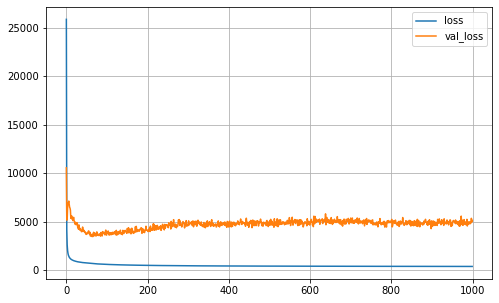

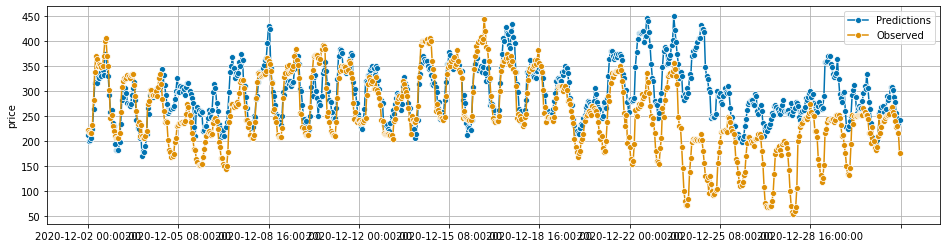

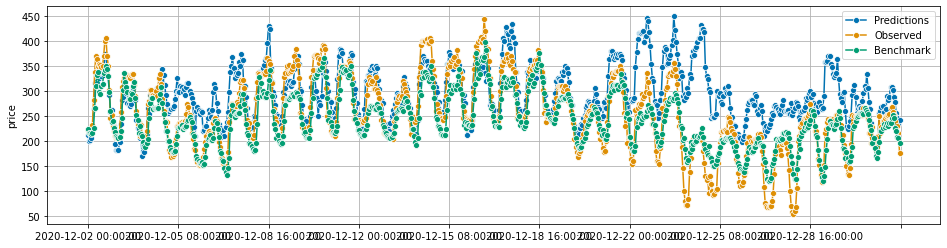

In [88]:
y_valid_pred = pd.Series(model.predict(X_valid).flatten())
y_valid_pred.index = y_valid.index

y_pred_external = pd.Series(external_predictions.loc[y_valid.index,:].iloc[:,0])
valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()
plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
plt.grid()

In [89]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))

Train on 25416 samples, validate on 720 samples
Epoch 1/200
25416/25416 [==============================] - 2s 80us/sample - loss: 9395.6034 - val_loss: 6378.1228
Epoch 2/200
25416/25416 [==============================] - 1s 56us/sample - loss: 1323.2730 - val_loss: 5729.0509
Epoch 3/200
25416/25416 [==============================] - 1s 53us/sample - loss: 1114.2882 - val_loss: 4911.0726
Epoch 4/200
25416/25416 [==============================] - 1s 55us/sample - loss: 1007.2836 - val_loss: 5079.6879
Epoch 5/200
25416/25416 [==============================] - 1s 58us/sample - loss: 939.2908 - val_loss: 5098.6748
Epoch 6/200
25416/25416 [==============================] - 1s 52us/sample - loss: 882.3541 - val_loss: 4170.4181
Epoch 7/200
25416/25416 [==============================] - 1s 51us/sample - loss: 840.6281 - val_loss: 5078.5288
Epoch 8/200
25416/25416 [==============================] - 1s 53us/sample - loss: 802.1957 - val_loss: 5657.7251
Epoch 9/200
25416/25416 [===================

25416/25416 [==============================] - 1s 38us/sample - loss: 229.3174 - val_loss: 8423.3075
Epoch 73/200
25416/25416 [==============================] - 1s 37us/sample - loss: 227.8671 - val_loss: 8441.8321
Epoch 74/200
25416/25416 [==============================] - 1s 37us/sample - loss: 227.7674 - val_loss: 9194.0756
Epoch 75/200
25416/25416 [==============================] - 1s 38us/sample - loss: 225.8272 - val_loss: 9580.4403
Epoch 76/200
25416/25416 [==============================] - 1s 38us/sample - loss: 223.5293 - val_loss: 9016.4792
Epoch 77/200
25416/25416 [==============================] - 1s 38us/sample - loss: 222.2757 - val_loss: 9002.1713
Epoch 78/200
25416/25416 [==============================] - 1s 37us/sample - loss: 219.0217 - val_loss: 9231.7181
Epoch 79/200
25416/25416 [==============================] - 1s 37us/sample - loss: 217.1704 - val_loss: 8662.5907
Epoch 80/200
25416/25416 [==============================] - 1s 38us/sample - loss: 218.2193 - val_los

25416/25416 [==============================] - 1s 37us/sample - loss: 168.7632 - val_loss: 7747.2324
Epoch 144/200
25416/25416 [==============================] - 1s 37us/sample - loss: 167.7148 - val_loss: 8533.6649
Epoch 145/200
25416/25416 [==============================] - 1s 37us/sample - loss: 168.0360 - val_loss: 7449.7554
Epoch 146/200
25416/25416 [==============================] - 1s 37us/sample - loss: 168.8889 - val_loss: 7729.8300
Epoch 147/200
25416/25416 [==============================] - 1s 37us/sample - loss: 166.7421 - val_loss: 7870.9105
Epoch 148/200
25416/25416 [==============================] - 1s 38us/sample - loss: 168.0886 - val_loss: 7640.3596
Epoch 149/200
25416/25416 [==============================] - 1s 39us/sample - loss: 167.9025 - val_loss: 8871.4577
Epoch 150/200
25416/25416 [==============================] - 1s 37us/sample - loss: 166.5049 - val_loss: 7423.4555
Epoch 151/200
25416/25416 [==============================] - 1s 38us/sample - loss: 167.9094 -

Validation error: 82.55210759224995, Benchmark error: 34.117237015574034


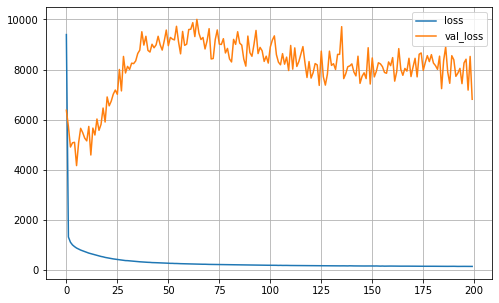

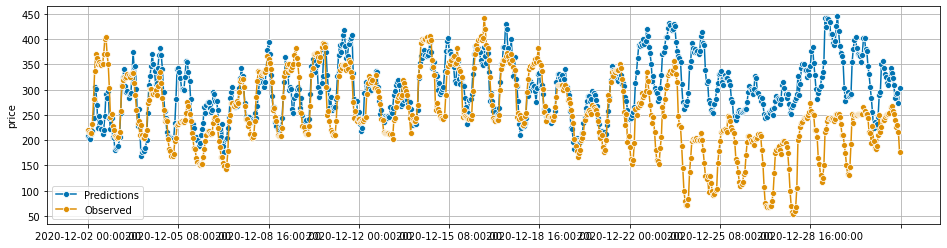

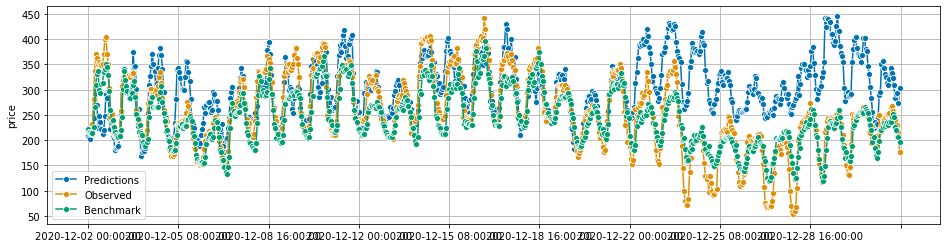

In [90]:
y_valid_pred = pd.Series(model.predict(X_valid).flatten())
y_valid_pred.index = y_valid.index

y_pred_external = pd.Series(external_predictions.loc[y_valid.index,:].iloc[:,0])
valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()
plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
plt.grid()

In [91]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))

Train on 25416 samples, validate on 720 samples
Epoch 1/200
25416/25416 [==============================] - 2s 77us/sample - loss: 4957.6026 - val_loss: 4702.7190
Epoch 2/200
25416/25416 [==============================] - 1s 55us/sample - loss: 1071.4177 - val_loss: 4385.0870
Epoch 3/200
25416/25416 [==============================] - 1s 51us/sample - loss: 943.8916 - val_loss: 4611.6309
Epoch 4/200
25416/25416 [==============================] - 1s 58us/sample - loss: 868.9735 - val_loss: 4624.7088
Epoch 5/200
25416/25416 [==============================] - 2s 66us/sample - loss: 819.9995 - val_loss: 5089.8435
Epoch 6/200
25416/25416 [==============================] - 2s 71us/sample - loss: 783.7251 - val_loss: 5321.6154
Epoch 7/200
25416/25416 [==============================] - 2s 64us/sample - loss: 745.4381 - val_loss: 4582.8008
Epoch 8/200
25416/25416 [==============================] - 1s 53us/sample - loss: 711.4505 - val_loss: 4688.7090
Epoch 9/200
25416/25416 [=====================

25416/25416 [==============================] - 1s 58us/sample - loss: 192.4106 - val_loss: 6834.8712
Epoch 73/200
25416/25416 [==============================] - 1s 56us/sample - loss: 198.0510 - val_loss: 6642.3714
Epoch 74/200
25416/25416 [==============================] - 2s 65us/sample - loss: 192.1065 - val_loss: 6825.7933
Epoch 75/200
25416/25416 [==============================] - 2s 65us/sample - loss: 194.8228 - val_loss: 6913.4020
Epoch 76/200
25416/25416 [==============================] - 1s 57us/sample - loss: 187.8369 - val_loss: 5778.4556
Epoch 77/200
25416/25416 [==============================] - 1s 53us/sample - loss: 192.2288 - val_loss: 6108.5112
Epoch 78/200
25416/25416 [==============================] - 1s 53us/sample - loss: 187.4471 - val_loss: 5669.0643
Epoch 79/200
25416/25416 [==============================] - 1s 51us/sample - loss: 179.9874 - val_loss: 5817.8498
Epoch 80/200
25416/25416 [==============================] - 1s 52us/sample - loss: 185.5509 - val_los

25416/25416 [==============================] - 1s 47us/sample - loss: 141.9984 - val_loss: 6644.0826
Epoch 144/200
25416/25416 [==============================] - 1s 40us/sample - loss: 127.4168 - val_loss: 7039.5212
Epoch 145/200
25416/25416 [==============================] - 1s 41us/sample - loss: 133.5758 - val_loss: 6455.6520
Epoch 146/200
25416/25416 [==============================] - 1s 40us/sample - loss: 127.4444 - val_loss: 6340.9361
Epoch 147/200
25416/25416 [==============================] - 1s 40us/sample - loss: 144.4357 - val_loss: 5984.6842
Epoch 148/200
25416/25416 [==============================] - 1s 49us/sample - loss: 125.4594 - val_loss: 6311.1005
Epoch 149/200
25416/25416 [==============================] - 1s 49us/sample - loss: 128.1554 - val_loss: 6370.9431
Epoch 150/200
25416/25416 [==============================] - 1s 47us/sample - loss: 128.3460 - val_loss: 6310.0092
Epoch 151/200
25416/25416 [==============================] - 1s 44us/sample - loss: 132.1176 -

Validation error: 78.1989695693874, Benchmark error: 34.117237015574034


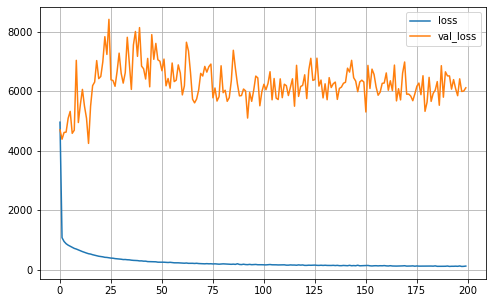

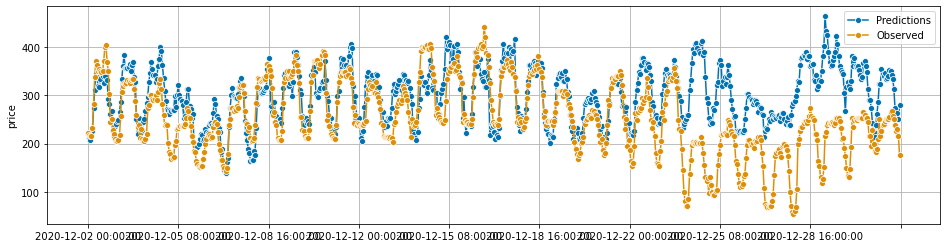

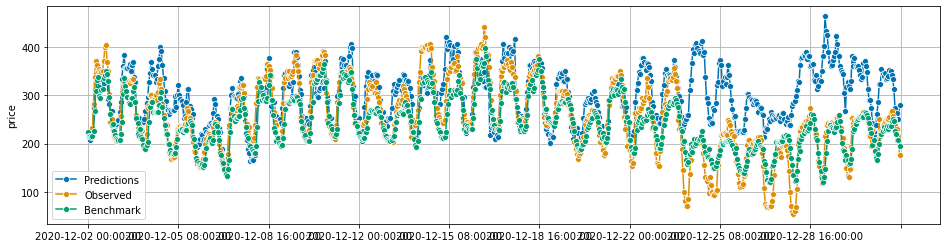

In [93]:
y_valid_pred = pd.Series(model.predict(X_valid).flatten())
y_valid_pred.index = y_valid.index

y_pred_external = pd.Series(external_predictions.loc[y_valid.index,:].iloc[:,0])
valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()
plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
plt.grid()

## Reccurent networks

In [54]:
X_train_reshaped = X_train.reshape((-1, 24, X_train.shape[1]))
y_train_reshaped = y_train.values.reshape((-1, 24, 1))
X_valid_reshaped = X_valid.reshape((-1, 24, X_valid.shape[1]))
y_valid_reshaped = y_valid.values.reshape((-1, 24, 1))

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 4s 3ms/sample - loss: 52130.2104 - mean_absolute_error: 220.3614 - val_loss: 69820.9219 - val_mean_absolute_error: 253.6952
Epoch 2/1000
1059/1059 [==============================] - 1s 487us/sample - loss: 51710.1291 - mean_absolute_error: 219.4175 - val_loss: 68977.1406 - val_mean_absolute_error: 252.0423
Epoch 3/1000
1059/1059 [==============================] - 1s 570us/sample - loss: 50840.3023 - mean_absolute_error: 217.4464 - val_loss: 68017.6484 - val_mean_absolute_error: 250.1508
Epoch 4/1000
1059/1059 [==============================] - 1s 526us/sample - loss: 49971.2519 - mean_absolute_error: 215.4433 - val_loss: 67170.8281 - val_mean_absolute_error: 248.4568
Epoch 5/1000
1059/1059 [==============================] - 1s 519us/sample - loss: 49258.6523 - mean_absolute_error: 213.7865 - val_loss: 66422.8672 - val_mean_absolute_error: 246.9449
Epoch 6/1000
1059/1059 [============

Epoch 45/1000
1059/1059 [==============================] - 1s 551us/sample - loss: 32092.3490 - mean_absolute_error: 168.9888 - val_loss: 46384.2695 - val_mean_absolute_error: 202.4314
Epoch 46/1000
1059/1059 [==============================] - 1s 570us/sample - loss: 31747.0439 - mean_absolute_error: 167.9731 - val_loss: 45971.9258 - val_mean_absolute_error: 201.4148
Epoch 47/1000
1059/1059 [==============================] - 1s 542us/sample - loss: 31404.4020 - mean_absolute_error: 166.9548 - val_loss: 45561.6523 - val_mean_absolute_error: 200.3970
Epoch 48/1000
1059/1059 [==============================] - 1s 478us/sample - loss: 31063.7715 - mean_absolute_error: 165.9326 - val_loss: 45151.8789 - val_mean_absolute_error: 199.3770
Epoch 49/1000
1059/1059 [==============================] - 1s 653us/sample - loss: 30726.0015 - mean_absolute_error: 164.9140 - val_loss: 44744.1289 - val_mean_absolute_error: 198.3586
Epoch 50/1000
1059/1059 [==============================] - 1s 589us/sample 

1059/1059 [==============================] - 1s 672us/sample - loss: 19370.8980 - mean_absolute_error: 126.5287 - val_loss: 30773.4395 - val_mean_absolute_error: 160.6386
Epoch 90/1000
1059/1059 [==============================] - 0s 461us/sample - loss: 19135.8325 - mean_absolute_error: 125.6257 - val_loss: 30475.7129 - val_mean_absolute_error: 159.7576
Epoch 91/1000
1059/1059 [==============================] - 1s 521us/sample - loss: 18901.3515 - mean_absolute_error: 124.7209 - val_loss: 30178.5742 - val_mean_absolute_error: 158.8758
Epoch 92/1000
1059/1059 [==============================] - 1s 583us/sample - loss: 18668.5568 - mean_absolute_error: 123.8166 - val_loss: 29881.8027 - val_mean_absolute_error: 157.9902
Epoch 93/1000
1059/1059 [==============================] - 1s 574us/sample - loss: 18439.0878 - mean_absolute_error: 122.9095 - val_loss: 29589.6836 - val_mean_absolute_error: 157.1136
Epoch 94/1000
1059/1059 [==============================] - 0s 437us/sample - loss: 18212.

Epoch 133/1000
1059/1059 [==============================] - 1s 505us/sample - loss: 10950.5480 - mean_absolute_error: 89.3397 - val_loss: 19688.1855 - val_mean_absolute_error: 124.5828
Epoch 134/1000
1059/1059 [==============================] - 1s 518us/sample - loss: 10801.2787 - mean_absolute_error: 88.5672 - val_loss: 19481.2422 - val_mean_absolute_error: 123.8310
Epoch 135/1000
1059/1059 [==============================] - 0s 441us/sample - loss: 10654.9329 - mean_absolute_error: 87.8044 - val_loss: 19278.1367 - val_mean_absolute_error: 123.0878
Epoch 136/1000
1059/1059 [==============================] - 1s 504us/sample - loss: 10509.8862 - mean_absolute_error: 87.0449 - val_loss: 19075.2793 - val_mean_absolute_error: 122.3422
Epoch 137/1000
1059/1059 [==============================] - 1s 511us/sample - loss: 10365.9662 - mean_absolute_error: 86.2834 - val_loss: 18872.4688 - val_mean_absolute_error: 121.5920
Epoch 138/1000
1059/1059 [==============================] - 1s 503us/sample

1059/1059 [==============================] - 0s 466us/sample - loss: 5970.9944 - mean_absolute_error: 60.4351 - val_loss: 12303.3809 - val_mean_absolute_error: 94.6818
Epoch 178/1000
1059/1059 [==============================] - 0s 455us/sample - loss: 5891.0828 - mean_absolute_error: 59.9251 - val_loss: 12172.5264 - val_mean_absolute_error: 94.0859
Epoch 179/1000
1059/1059 [==============================] - 0s 437us/sample - loss: 5813.3676 - mean_absolute_error: 59.4281 - val_loss: 12045.6377 - val_mean_absolute_error: 93.5069
Epoch 180/1000
1059/1059 [==============================] - 1s 557us/sample - loss: 5735.3711 - mean_absolute_error: 58.9172 - val_loss: 11914.5811 - val_mean_absolute_error: 92.9066
Epoch 181/1000
1059/1059 [==============================] - 1s 623us/sample - loss: 5659.7238 - mean_absolute_error: 58.4310 - val_loss: 11791.3330 - val_mean_absolute_error: 92.3405
Epoch 182/1000
1059/1059 [==============================] - 1s 622us/sample - loss: 5586.5130 - mean

Epoch 222/1000
1059/1059 [==============================] - 0s 450us/sample - loss: 3173.1701 - mean_absolute_error: 39.6134 - val_loss: 7641.8662 - val_mean_absolute_error: 71.6339
Epoch 223/1000
1059/1059 [==============================] - 0s 455us/sample - loss: 3133.8644 - mean_absolute_error: 39.3073 - val_loss: 7563.8188 - val_mean_absolute_error: 71.2314
Epoch 224/1000
1059/1059 [==============================] - 0s 426us/sample - loss: 3091.5537 - mean_absolute_error: 38.9478 - val_loss: 7490.1064 - val_mean_absolute_error: 70.8360
Epoch 225/1000
1059/1059 [==============================] - 1s 518us/sample - loss: 3051.3345 - mean_absolute_error: 38.6087 - val_loss: 7413.8613 - val_mean_absolute_error: 70.4285
Epoch 226/1000
1059/1059 [==============================] - 1s 483us/sample - loss: 3011.0562 - mean_absolute_error: 38.2765 - val_loss: 7341.3018 - val_mean_absolute_error: 70.0379
Epoch 227/1000
1059/1059 [==============================] - 1s 482us/sample - loss: 2972.6

1059/1059 [==============================] - 1s 609us/sample - loss: 1846.6655 - mean_absolute_error: 27.9886 - val_loss: 4963.2515 - val_mean_absolute_error: 56.8180
Epoch 268/1000
1059/1059 [==============================] - 1s 569us/sample - loss: 1827.2202 - mean_absolute_error: 27.8120 - val_loss: 4923.6309 - val_mean_absolute_error: 56.5740
Epoch 269/1000
1059/1059 [==============================] - 1s 533us/sample - loss: 1808.7396 - mean_absolute_error: 27.6367 - val_loss: 4882.6768 - val_mean_absolute_error: 56.2974
Epoch 270/1000
1059/1059 [==============================] - 1s 492us/sample - loss: 1789.8749 - mean_absolute_error: 27.4581 - val_loss: 4841.2490 - val_mean_absolute_error: 56.0223
Epoch 271/1000
1059/1059 [==============================] - 1s 559us/sample - loss: 1772.2470 - mean_absolute_error: 27.3021 - val_loss: 4800.4951 - val_mean_absolute_error: 55.7723
Epoch 272/1000
1059/1059 [==============================] - 1s 550us/sample - loss: 1754.7797 - mean_abso

1059/1059 [==============================] - 1s 526us/sample - loss: 1257.4769 - mean_absolute_error: 22.5710 - val_loss: 3365.9680 - val_mean_absolute_error: 46.4167
Epoch 313/1000
1059/1059 [==============================] - 1s 530us/sample - loss: 1247.7410 - mean_absolute_error: 22.4633 - val_loss: 3342.1404 - val_mean_absolute_error: 46.2009
Epoch 314/1000
1059/1059 [==============================] - 1s 527us/sample - loss: 1240.8133 - mean_absolute_error: 22.4522 - val_loss: 3307.6565 - val_mean_absolute_error: 45.8241
Epoch 315/1000
1059/1059 [==============================] - 1s 515us/sample - loss: 1229.5878 - mean_absolute_error: 22.3199 - val_loss: 3267.6670 - val_mean_absolute_error: 45.5700
Epoch 316/1000
1059/1059 [==============================] - 1s 506us/sample - loss: 1219.5875 - mean_absolute_error: 22.1952 - val_loss: 3273.9517 - val_mean_absolute_error: 45.6751
Epoch 317/1000
1059/1059 [==============================] - 1s 539us/sample - loss: 1209.4799 - mean_abso

Epoch 357/1000
1059/1059 [==============================] - 0s 460us/sample - loss: 951.9455 - mean_absolute_error: 19.5176 - val_loss: 2505.6138 - val_mean_absolute_error: 38.4805
Epoch 358/1000
1059/1059 [==============================] - 0s 460us/sample - loss: 948.0822 - mean_absolute_error: 19.4781 - val_loss: 2506.1006 - val_mean_absolute_error: 38.6567
Epoch 359/1000
1059/1059 [==============================] - 0s 458us/sample - loss: 943.0961 - mean_absolute_error: 19.4136 - val_loss: 2487.5696 - val_mean_absolute_error: 38.2972
Epoch 360/1000
1059/1059 [==============================] - 0s 458us/sample - loss: 936.5939 - mean_absolute_error: 19.3173 - val_loss: 2509.3484 - val_mean_absolute_error: 38.4118
Epoch 361/1000
1059/1059 [==============================] - 0s 461us/sample - loss: 932.8698 - mean_absolute_error: 19.3002 - val_loss: 2480.6831 - val_mean_absolute_error: 38.2832
Epoch 362/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 933.7215 - 

1059/1059 [==============================] - 0s 450us/sample - loss: 798.6336 - mean_absolute_error: 17.8113 - val_loss: 2159.2622 - val_mean_absolute_error: 36.0997
Epoch 403/1000
1059/1059 [==============================] - 0s 453us/sample - loss: 795.7264 - mean_absolute_error: 17.7480 - val_loss: 2146.3179 - val_mean_absolute_error: 35.8892
Epoch 404/1000
1059/1059 [==============================] - 0s 463us/sample - loss: 794.0099 - mean_absolute_error: 17.7448 - val_loss: 2095.6023 - val_mean_absolute_error: 35.3018
Epoch 405/1000
1059/1059 [==============================] - 0s 453us/sample - loss: 792.2577 - mean_absolute_error: 17.7214 - val_loss: 2115.1848 - val_mean_absolute_error: 35.4223
Epoch 406/1000
1059/1059 [==============================] - 1s 487us/sample - loss: 787.4504 - mean_absolute_error: 17.6744 - val_loss: 2122.7236 - val_mean_absolute_error: 35.5665
Epoch 407/1000
1059/1059 [==============================] - 1s 493us/sample - loss: 784.6033 - mean_absolute_e

1059/1059 [==============================] - 1s 481us/sample - loss: 696.4172 - mean_absolute_error: 16.4548 - val_loss: 1837.8676 - val_mean_absolute_error: 32.8535
Epoch 448/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 692.7279 - mean_absolute_error: 16.3747 - val_loss: 1843.7087 - val_mean_absolute_error: 33.0041
Epoch 449/1000
1059/1059 [==============================] - 1s 488us/sample - loss: 690.7737 - mean_absolute_error: 16.3715 - val_loss: 1821.7819 - val_mean_absolute_error: 32.7428
Epoch 450/1000
1059/1059 [==============================] - 1s 480us/sample - loss: 688.7698 - mean_absolute_error: 16.3358 - val_loss: 1816.1229 - val_mean_absolute_error: 32.6919
Epoch 451/1000
1059/1059 [==============================] - 0s 456us/sample - loss: 695.3236 - mean_absolute_error: 16.5131 - val_loss: 1797.1486 - val_mean_absolute_error: 32.2943
Epoch 452/1000
1059/1059 [==============================] - 0s 460us/sample - loss: 694.1276 - mean_absolute_e

1059/1059 [==============================] - 0s 471us/sample - loss: 618.9819 - mean_absolute_error: 15.5085 - val_loss: 1725.7128 - val_mean_absolute_error: 31.8216
Epoch 493/1000
1059/1059 [==============================] - 0s 455us/sample - loss: 613.8981 - mean_absolute_error: 15.3726 - val_loss: 1690.3325 - val_mean_absolute_error: 31.5729
Epoch 494/1000
1059/1059 [==============================] - 0s 462us/sample - loss: 607.6168 - mean_absolute_error: 15.2365 - val_loss: 1721.3308 - val_mean_absolute_error: 31.7530
Epoch 495/1000
1059/1059 [==============================] - 0s 450us/sample - loss: 602.4879 - mean_absolute_error: 15.1003 - val_loss: 1715.4144 - val_mean_absolute_error: 31.9282
Epoch 496/1000
1059/1059 [==============================] - 0s 444us/sample - loss: 600.8986 - mean_absolute_error: 15.0744 - val_loss: 1709.3783 - val_mean_absolute_error: 31.9814
Epoch 497/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 598.4948 - mean_absolute_e

1059/1059 [==============================] - 0s 460us/sample - loss: 553.3092 - mean_absolute_error: 14.4721 - val_loss: 1779.5411 - val_mean_absolute_error: 33.7646
Epoch 538/1000
1059/1059 [==============================] - 0s 471us/sample - loss: 548.1232 - mean_absolute_error: 14.3554 - val_loss: 1792.9390 - val_mean_absolute_error: 33.9810
Epoch 539/1000
1059/1059 [==============================] - 0s 459us/sample - loss: 544.9511 - mean_absolute_error: 14.2960 - val_loss: 1914.7678 - val_mean_absolute_error: 35.1791
Epoch 540/1000
1059/1059 [==============================] - 0s 470us/sample - loss: 542.9881 - mean_absolute_error: 14.2702 - val_loss: 1878.0168 - val_mean_absolute_error: 34.9523
Epoch 541/1000
1059/1059 [==============================] - 1s 487us/sample - loss: 540.4517 - mean_absolute_error: 14.1885 - val_loss: 1855.9315 - val_mean_absolute_error: 34.5656
Epoch 542/1000
1059/1059 [==============================] - 1s 480us/sample - loss: 538.1979 - mean_absolute_e

1059/1059 [==============================] - 1s 588us/sample - loss: 496.6020 - mean_absolute_error: 13.5501 - val_loss: 1948.4025 - val_mean_absolute_error: 35.9458
Epoch 583/1000
1059/1059 [==============================] - 1s 578us/sample - loss: 496.9384 - mean_absolute_error: 13.5492 - val_loss: 1888.3528 - val_mean_absolute_error: 35.3602
Epoch 584/1000
1059/1059 [==============================] - 1s 524us/sample - loss: 496.7596 - mean_absolute_error: 13.5813 - val_loss: 2005.0441 - val_mean_absolute_error: 36.4512
Epoch 585/1000
1059/1059 [==============================] - 1s 589us/sample - loss: 494.4748 - mean_absolute_error: 13.5271 - val_loss: 1919.9889 - val_mean_absolute_error: 35.4785
Epoch 586/1000
1059/1059 [==============================] - 1s 596us/sample - loss: 493.5493 - mean_absolute_error: 13.5135 - val_loss: 1894.9625 - val_mean_absolute_error: 35.3663
Epoch 587/1000
1059/1059 [==============================] - 1s 555us/sample - loss: 491.8650 - mean_absolute_e

1059/1059 [==============================] - 1s 688us/sample - loss: 468.8917 - mean_absolute_error: 13.2335 - val_loss: 2281.3943 - val_mean_absolute_error: 39.4220
Epoch 628/1000
1059/1059 [==============================] - 1s 941us/sample - loss: 468.7848 - mean_absolute_error: 13.2775 - val_loss: 2249.4321 - val_mean_absolute_error: 39.1124
Epoch 629/1000
1059/1059 [==============================] - 1s 735us/sample - loss: 468.7141 - mean_absolute_error: 13.2131 - val_loss: 2238.6697 - val_mean_absolute_error: 38.7231
Epoch 630/1000
1059/1059 [==============================] - 1s 873us/sample - loss: 467.3863 - mean_absolute_error: 13.1906 - val_loss: 2217.2263 - val_mean_absolute_error: 38.7832
Epoch 631/1000
1059/1059 [==============================] - 1s 668us/sample - loss: 482.9202 - mean_absolute_error: 13.6410 - val_loss: 2238.4592 - val_mean_absolute_error: 39.0914
Epoch 632/1000
1059/1059 [==============================] - 1s 512us/sample - loss: 497.1843 - mean_absolute_e

1059/1059 [==============================] - 1s 480us/sample - loss: 437.4751 - mean_absolute_error: 12.6685 - val_loss: 2620.1733 - val_mean_absolute_error: 41.8878
Epoch 673/1000
1059/1059 [==============================] - 1s 483us/sample - loss: 441.5238 - mean_absolute_error: 12.7793 - val_loss: 2774.2122 - val_mean_absolute_error: 43.0643
Epoch 674/1000
1059/1059 [==============================] - 1s 498us/sample - loss: 445.3661 - mean_absolute_error: 12.9043 - val_loss: 2527.8635 - val_mean_absolute_error: 41.2920
Epoch 675/1000
1059/1059 [==============================] - 1s 497us/sample - loss: 447.9704 - mean_absolute_error: 12.9388 - val_loss: 2684.4353 - val_mean_absolute_error: 42.1111
Epoch 676/1000
1059/1059 [==============================] - 1s 537us/sample - loss: 443.7162 - mean_absolute_error: 12.9112 - val_loss: 2757.0991 - val_mean_absolute_error: 42.7595
Epoch 677/1000
1059/1059 [==============================] - 1s 522us/sample - loss: 440.0868 - mean_absolute_e

1059/1059 [==============================] - 1s 490us/sample - loss: 414.3805 - mean_absolute_error: 12.3311 - val_loss: 2510.2134 - val_mean_absolute_error: 40.9103
Epoch 718/1000
1059/1059 [==============================] - 1s 493us/sample - loss: 413.0362 - mean_absolute_error: 12.2978 - val_loss: 2421.4995 - val_mean_absolute_error: 40.2400
Epoch 719/1000
1059/1059 [==============================] - 1s 488us/sample - loss: 411.7108 - mean_absolute_error: 12.2614 - val_loss: 2561.9873 - val_mean_absolute_error: 41.2208
Epoch 720/1000
1059/1059 [==============================] - 1s 499us/sample - loss: 411.3085 - mean_absolute_error: 12.2720 - val_loss: 2444.9851 - val_mean_absolute_error: 40.3594
Epoch 721/1000
1059/1059 [==============================] - 1s 493us/sample - loss: 410.5267 - mean_absolute_error: 12.2441 - val_loss: 2471.1484 - val_mean_absolute_error: 40.4545
Epoch 722/1000
1059/1059 [==============================] - 1s 493us/sample - loss: 409.2736 - mean_absolute_e

1059/1059 [==============================] - 0s 453us/sample - loss: 391.7854 - mean_absolute_error: 12.0069 - val_loss: 2327.0144 - val_mean_absolute_error: 39.3617
Epoch 763/1000
1059/1059 [==============================] - 0s 454us/sample - loss: 389.9291 - mean_absolute_error: 11.9608 - val_loss: 2377.5999 - val_mean_absolute_error: 39.7086
Epoch 764/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 389.3777 - mean_absolute_error: 11.9337 - val_loss: 2268.9050 - val_mean_absolute_error: 38.5988
Epoch 765/1000
1059/1059 [==============================] - 0s 453us/sample - loss: 392.1629 - mean_absolute_error: 12.0165 - val_loss: 2222.5044 - val_mean_absolute_error: 38.3784
Epoch 766/1000
1059/1059 [==============================] - 0s 456us/sample - loss: 400.3844 - mean_absolute_error: 12.3179 - val_loss: 2218.6418 - val_mean_absolute_error: 38.5603
Epoch 767/1000
1059/1059 [==============================] - 0s 454us/sample - loss: 463.3489 - mean_absolute_e

1059/1059 [==============================] - 0s 452us/sample - loss: 374.2462 - mean_absolute_error: 11.7288 - val_loss: 2327.2805 - val_mean_absolute_error: 39.2077
Epoch 808/1000
1059/1059 [==============================] - 0s 452us/sample - loss: 372.4758 - mean_absolute_error: 11.6951 - val_loss: 2104.9873 - val_mean_absolute_error: 37.4288
Epoch 809/1000
1059/1059 [==============================] - 0s 454us/sample - loss: 374.8624 - mean_absolute_error: 11.7962 - val_loss: 2337.7727 - val_mean_absolute_error: 38.7500
Epoch 810/1000
1059/1059 [==============================] - 0s 453us/sample - loss: 372.7252 - mean_absolute_error: 11.7165 - val_loss: 2187.7517 - val_mean_absolute_error: 37.7713
Epoch 811/1000
1059/1059 [==============================] - 0s 446us/sample - loss: 371.5961 - mean_absolute_error: 11.6962 - val_loss: 2113.8518 - val_mean_absolute_error: 36.9221
Epoch 812/1000
1059/1059 [==============================] - 0s 462us/sample - loss: 376.8053 - mean_absolute_e

1059/1059 [==============================] - 0s 449us/sample - loss: 350.9262 - mean_absolute_error: 11.3058 - val_loss: 2117.7402 - val_mean_absolute_error: 36.7909
Epoch 853/1000
1059/1059 [==============================] - 0s 461us/sample - loss: 349.9458 - mean_absolute_error: 11.2648 - val_loss: 2081.2468 - val_mean_absolute_error: 36.5375
Epoch 854/1000
1059/1059 [==============================] - 0s 464us/sample - loss: 349.5459 - mean_absolute_error: 11.2608 - val_loss: 2065.4099 - val_mean_absolute_error: 36.3670
Epoch 855/1000
1059/1059 [==============================] - 0s 452us/sample - loss: 350.6234 - mean_absolute_error: 11.2996 - val_loss: 2163.6082 - val_mean_absolute_error: 37.3429
Epoch 856/1000
1059/1059 [==============================] - 0s 451us/sample - loss: 349.0282 - mean_absolute_error: 11.2745 - val_loss: 2058.7856 - val_mean_absolute_error: 36.4142
Epoch 857/1000
1059/1059 [==============================] - 0s 453us/sample - loss: 348.7440 - mean_absolute_e

1059/1059 [==============================] - 1s 485us/sample - loss: 333.2289 - mean_absolute_error: 11.0092 - val_loss: 2160.5432 - val_mean_absolute_error: 37.4710
Epoch 898/1000
1059/1059 [==============================] - 0s 452us/sample - loss: 333.2129 - mean_absolute_error: 11.0064 - val_loss: 2144.9172 - val_mean_absolute_error: 37.3211
Epoch 899/1000
1059/1059 [==============================] - 0s 456us/sample - loss: 333.3075 - mean_absolute_error: 11.0127 - val_loss: 2108.3435 - val_mean_absolute_error: 36.8847
Epoch 900/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 338.6660 - mean_absolute_error: 11.2266 - val_loss: 2129.5684 - val_mean_absolute_error: 37.1828
Epoch 901/1000
1059/1059 [==============================] - 0s 448us/sample - loss: 343.0116 - mean_absolute_error: 11.3357 - val_loss: 2217.8865 - val_mean_absolute_error: 37.9781
Epoch 902/1000
1059/1059 [==============================] - 0s 454us/sample - loss: 352.0758 - mean_absolute_e

1059/1059 [==============================] - 0s 459us/sample - loss: 320.6747 - mean_absolute_error: 10.8203 - val_loss: 2126.3391 - val_mean_absolute_error: 37.8195
Epoch 943/1000
1059/1059 [==============================] - 0s 452us/sample - loss: 319.8741 - mean_absolute_error: 10.8055 - val_loss: 2112.7383 - val_mean_absolute_error: 37.6784
Epoch 944/1000
1059/1059 [==============================] - 0s 455us/sample - loss: 319.3214 - mean_absolute_error: 10.7791 - val_loss: 2087.2732 - val_mean_absolute_error: 37.4045
Epoch 945/1000
1059/1059 [==============================] - 0s 450us/sample - loss: 318.6691 - mean_absolute_error: 10.7717 - val_loss: 2104.6670 - val_mean_absolute_error: 37.5881
Epoch 946/1000
1059/1059 [==============================] - 0s 447us/sample - loss: 318.3656 - mean_absolute_error: 10.7724 - val_loss: 2136.2104 - val_mean_absolute_error: 37.8032
Epoch 947/1000
1059/1059 [==============================] - 0s 454us/sample - loss: 317.7924 - mean_absolute_e

1059/1059 [==============================] - 0s 463us/sample - loss: 321.4972 - mean_absolute_error: 11.0568 - val_loss: 2104.9377 - val_mean_absolute_error: 37.1222
Epoch 988/1000
1059/1059 [==============================] - 0s 471us/sample - loss: 318.2009 - mean_absolute_error: 11.0443 - val_loss: 2215.6204 - val_mean_absolute_error: 38.2513
Epoch 989/1000
1059/1059 [==============================] - 0s 452us/sample - loss: 320.7264 - mean_absolute_error: 11.0306 - val_loss: 2164.3774 - val_mean_absolute_error: 37.9927
Epoch 990/1000
1059/1059 [==============================] - 0s 458us/sample - loss: 323.8336 - mean_absolute_error: 11.2125 - val_loss: 2036.2546 - val_mean_absolute_error: 36.4560
Epoch 991/1000
1059/1059 [==============================] - 1s 479us/sample - loss: 329.4775 - mean_absolute_error: 11.2995 - val_loss: 2113.5129 - val_mean_absolute_error: 37.2493
Epoch 992/1000
1059/1059 [==============================] - 0s 457us/sample - loss: 320.8795 - mean_absolute_e

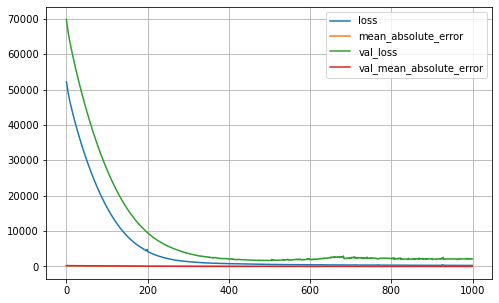

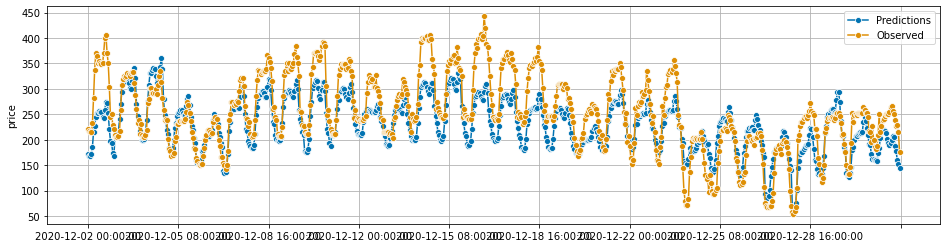

In [59]:
model = keras.models.Sequential([
    keras.layers.GRU(32),
    keras.layers.Dense(24),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1500, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
)


y_valid_pred = pd.Series(model.predict(X_valid_reshaped).flatten())
y_valid_pred.index = y_valid.index

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 10s 9ms/sample - loss: 52020.1210 - mean_absolute_error: 220.1517 - val_loss: 69500.2734 - val_mean_absolute_error: 253.1922
Epoch 2/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 51164.7640 - mean_absolute_error: 218.2374 - val_loss: 68565.4297 - val_mean_absolute_error: 251.2965
Epoch 3/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 50473.4837 - mean_absolute_error: 216.6290 - val_loss: 67870.1641 - val_mean_absolute_error: 249.9128
Epoch 4/1000
1059/1059 [==============================] - 1s 990us/sample - loss: 49891.0890 - mean_absolute_error: 215.2830 - val_loss: 67217.7891 - val_mean_absolute_error: 248.5989
Epoch 5/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 49350.2170 - mean_absolute_error: 214.0189 - val_loss: 66603.7812 - val_mean_absolute_error: 247.3607
Epoch 6/1000
1059/1059 [=================

1059/1059 [==============================] - 1s 965us/sample - loss: 32665.6794 - mean_absolute_error: 170.7211 - val_loss: 47066.1445 - val_mean_absolute_error: 204.1658
Epoch 46/1000
1059/1059 [==============================] - 1s 952us/sample - loss: 32321.4407 - mean_absolute_error: 169.7110 - val_loss: 46654.8750 - val_mean_absolute_error: 203.1603
Epoch 47/1000
1059/1059 [==============================] - 1s 941us/sample - loss: 31980.3674 - mean_absolute_error: 168.6999 - val_loss: 46243.5625 - val_mean_absolute_error: 202.1495
Epoch 48/1000
1059/1059 [==============================] - 1s 971us/sample - loss: 31639.3602 - mean_absolute_error: 167.6969 - val_loss: 45836.9453 - val_mean_absolute_error: 201.1448
Epoch 49/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31300.3537 - mean_absolute_error: 166.6881 - val_loss: 45429.6797 - val_mean_absolute_error: 200.1346
Epoch 50/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 30963.0411

1059/1059 [==============================] - 1s 929us/sample - loss: 19833.8784 - mean_absolute_error: 128.3427 - val_loss: 31353.2383 - val_mean_absolute_error: 162.3987
Epoch 90/1000
1059/1059 [==============================] - 1s 949us/sample - loss: 19594.9025 - mean_absolute_error: 127.4365 - val_loss: 31051.4707 - val_mean_absolute_error: 161.5128
Epoch 91/1000
1059/1059 [==============================] - 1s 964us/sample - loss: 19357.3573 - mean_absolute_error: 126.5252 - val_loss: 30749.9062 - val_mean_absolute_error: 160.6226
Epoch 92/1000
1059/1059 [==============================] - 1s 975us/sample - loss: 19122.3309 - mean_absolute_error: 125.6237 - val_loss: 30453.4258 - val_mean_absolute_error: 159.7440
Epoch 93/1000
1059/1059 [==============================] - 1s 934us/sample - loss: 18889.9632 - mean_absolute_error: 124.7207 - val_loss: 30156.0820 - val_mean_absolute_error: 158.8596
Epoch 94/1000
1059/1059 [==============================] - 1s 922us/sample - loss: 18659.

1059/1059 [==============================] - 1s 1ms/sample - loss: 11253.8280 - mean_absolute_error: 90.9463 - val_loss: 20103.6836 - val_mean_absolute_error: 126.1201
Epoch 134/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 11101.7554 - mean_absolute_error: 90.1619 - val_loss: 19891.5547 - val_mean_absolute_error: 125.3541
Epoch 135/1000
1059/1059 [==============================] - 1s 985us/sample - loss: 10950.9519 - mean_absolute_error: 89.3881 - val_loss: 19685.0078 - val_mean_absolute_error: 124.6053
Epoch 136/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10803.2832 - mean_absolute_error: 88.6189 - val_loss: 19478.4043 - val_mean_absolute_error: 123.8514
Epoch 137/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10657.8604 - mean_absolute_error: 87.8619 - val_loss: 19277.1211 - val_mean_absolute_error: 123.1165
Epoch 138/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10512.9346 - mea

Epoch 178/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 6048.2546 - mean_absolute_error: 60.9565 - val_loss: 12426.5771 - val_mean_absolute_error: 95.2513
Epoch 179/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5967.2417 - mean_absolute_error: 60.4413 - val_loss: 12296.2207 - val_mean_absolute_error: 94.6639
Epoch 180/1000
1059/1059 [==============================] - 1s 980us/sample - loss: 5887.5375 - mean_absolute_error: 59.9271 - val_loss: 12165.5400 - val_mean_absolute_error: 94.0693
Epoch 181/1000
1059/1059 [==============================] - 1s 962us/sample - loss: 5809.2422 - mean_absolute_error: 59.4176 - val_loss: 12036.7949 - val_mean_absolute_error: 93.4827
Epoch 182/1000
1059/1059 [==============================] - 1s 985us/sample - loss: 5732.3878 - mean_absolute_error: 58.9253 - val_loss: 11910.9756 - val_mean_absolute_error: 92.9059
Epoch 183/1000
1059/1059 [==============================] - 1s 935us/sample - loss: 5657.

1059/1059 [==============================] - 1s 939us/sample - loss: 3590.1850 - mean_absolute_error: 44.2699 - val_loss: 7914.4702 - val_mean_absolute_error: 73.2066
Epoch 224/1000
1059/1059 [==============================] - 1s 954us/sample - loss: 3558.8761 - mean_absolute_error: 44.0482 - val_loss: 7844.1035 - val_mean_absolute_error: 72.8458
Epoch 225/1000
1059/1059 [==============================] - 1s 938us/sample - loss: 3527.4398 - mean_absolute_error: 43.8306 - val_loss: 7771.6040 - val_mean_absolute_error: 72.4751
Epoch 226/1000
1059/1059 [==============================] - 1s 878us/sample - loss: 3496.3287 - mean_absolute_error: 43.6086 - val_loss: 14396.7773 - val_mean_absolute_error: 92.7105
Epoch 227/1000
1059/1059 [==============================] - 1s 902us/sample - loss: 4415.9333 - mean_absolute_error: 46.1533 - val_loss: 7642.5029 - val_mean_absolute_error: 71.8132
Epoch 228/1000
1059/1059 [==============================] - 1s 866us/sample - loss: 3442.0835 - mean_abs

Epoch 268/1000
1059/1059 [==============================] - 1s 940us/sample - loss: 1853.5103 - mean_absolute_error: 27.8512 - val_loss: 5028.6333 - val_mean_absolute_error: 57.6948
Epoch 269/1000
1059/1059 [==============================] - 1s 872us/sample - loss: 1829.4519 - mean_absolute_error: 27.6058 - val_loss: 4971.3833 - val_mean_absolute_error: 57.2862
Epoch 270/1000
1059/1059 [==============================] - 1s 905us/sample - loss: 1806.6361 - mean_absolute_error: 27.3543 - val_loss: 4909.9766 - val_mean_absolute_error: 56.7861
Epoch 271/1000
1059/1059 [==============================] - 1s 909us/sample - loss: 1788.2743 - mean_absolute_error: 27.1901 - val_loss: 4852.4453 - val_mean_absolute_error: 56.4911
Epoch 272/1000
1059/1059 [==============================] - 1s 946us/sample - loss: 1771.1505 - mean_absolute_error: 27.0716 - val_loss: 4790.4307 - val_mean_absolute_error: 56.0946
Epoch 273/1000
1059/1059 [==============================] - 1s 893us/sample - loss: 1747.0

1059/1059 [==============================] - 1s 903us/sample - loss: 1190.9413 - mean_absolute_error: 21.5637 - val_loss: 3303.5447 - val_mean_absolute_error: 45.6540
Epoch 314/1000
1059/1059 [==============================] - 1s 887us/sample - loss: 1182.5396 - mean_absolute_error: 21.4618 - val_loss: 3317.6897 - val_mean_absolute_error: 45.6877
Epoch 315/1000
1059/1059 [==============================] - 1s 965us/sample - loss: 1173.5172 - mean_absolute_error: 21.3688 - val_loss: 3262.7344 - val_mean_absolute_error: 45.0592
Epoch 316/1000
1059/1059 [==============================] - 1s 878us/sample - loss: 1163.9527 - mean_absolute_error: 21.2816 - val_loss: 3241.5344 - val_mean_absolute_error: 45.1185
Epoch 317/1000
1059/1059 [==============================] - 1s 904us/sample - loss: 1154.6135 - mean_absolute_error: 21.1746 - val_loss: 3212.4207 - val_mean_absolute_error: 44.7304
Epoch 318/1000
1059/1059 [==============================] - 1s 873us/sample - loss: 1146.8710 - mean_abso

1059/1059 [==============================] - 1s 902us/sample - loss: 922.0335 - mean_absolute_error: 19.0001 - val_loss: 2571.1877 - val_mean_absolute_error: 40.1735
Epoch 359/1000
1059/1059 [==============================] - 1s 866us/sample - loss: 915.2652 - mean_absolute_error: 18.9096 - val_loss: 2574.6116 - val_mean_absolute_error: 40.2698
Epoch 360/1000
1059/1059 [==============================] - 1s 908us/sample - loss: 914.0272 - mean_absolute_error: 18.9559 - val_loss: 2537.7456 - val_mean_absolute_error: 39.8614
Epoch 361/1000
1059/1059 [==============================] - 1s 934us/sample - loss: 910.1804 - mean_absolute_error: 18.8941 - val_loss: 2489.1440 - val_mean_absolute_error: 39.5122
Epoch 362/1000
1059/1059 [==============================] - 1s 922us/sample - loss: 903.1273 - mean_absolute_error: 18.8198 - val_loss: 2510.1631 - val_mean_absolute_error: 39.8374
Epoch 363/1000
1059/1059 [==============================] - 1s 880us/sample - loss: 914.0467 - mean_absolute_e

1059/1059 [==============================] - 1s 1ms/sample - loss: 757.3426 - mean_absolute_error: 17.1136 - val_loss: 2119.5386 - val_mean_absolute_error: 36.5556
Epoch 404/1000
1059/1059 [==============================] - 1s 813us/sample - loss: 755.1501 - mean_absolute_error: 17.0678 - val_loss: 2100.7673 - val_mean_absolute_error: 36.6644
Epoch 405/1000
1059/1059 [==============================] - 1s 847us/sample - loss: 758.7881 - mean_absolute_error: 17.2236 - val_loss: 2093.3301 - val_mean_absolute_error: 35.9686
Epoch 406/1000
1059/1059 [==============================] - 1s 843us/sample - loss: 753.7272 - mean_absolute_error: 17.0714 - val_loss: 2073.4062 - val_mean_absolute_error: 36.0405
Epoch 407/1000
1059/1059 [==============================] - 1s 893us/sample - loss: 749.4579 - mean_absolute_error: 17.0411 - val_loss: 2000.0895 - val_mean_absolute_error: 35.2753
Epoch 408/1000
1059/1059 [==============================] - 1s 926us/sample - loss: 743.7643 - mean_absolute_err

1059/1059 [==============================] - 1s 845us/sample - loss: 631.8083 - mean_absolute_error: 15.3516 - val_loss: 1739.9801 - val_mean_absolute_error: 32.7187
Epoch 449/1000
1059/1059 [==============================] - 1s 833us/sample - loss: 629.6220 - mean_absolute_error: 15.3295 - val_loss: 1728.9670 - val_mean_absolute_error: 32.5986
Epoch 450/1000
1059/1059 [==============================] - 1s 798us/sample - loss: 627.0130 - mean_absolute_error: 15.3150 - val_loss: 1729.9938 - val_mean_absolute_error: 32.5964
Epoch 451/1000
1059/1059 [==============================] - 1s 802us/sample - loss: 629.3943 - mean_absolute_error: 15.2987 - val_loss: 2290.6470 - val_mean_absolute_error: 36.0767
Epoch 452/1000
1059/1059 [==============================] - 1s 820us/sample - loss: 658.7862 - mean_absolute_error: 15.8047 - val_loss: 1768.0898 - val_mean_absolute_error: 33.0386
Epoch 453/1000
1059/1059 [==============================] - 1s 888us/sample - loss: 648.4535 - mean_absolute_e

Epoch 494/1000
1059/1059 [==============================] - 1s 959us/sample - loss: 542.9334 - mean_absolute_error: 13.9999 - val_loss: 1533.7496 - val_mean_absolute_error: 29.9883
Epoch 495/1000
1059/1059 [==============================] - 1s 999us/sample - loss: 543.4585 - mean_absolute_error: 14.0245 - val_loss: 1534.7598 - val_mean_absolute_error: 29.9163
Epoch 496/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 540.2263 - mean_absolute_error: 13.9458 - val_loss: 1567.1989 - val_mean_absolute_error: 30.2065
Epoch 497/1000
1059/1059 [==============================] - 1s 976us/sample - loss: 544.1169 - mean_absolute_error: 14.0917 - val_loss: 1563.9193 - val_mean_absolute_error: 29.9376
Epoch 498/1000
1059/1059 [==============================] - 1s 978us/sample - loss: 546.2380 - mean_absolute_error: 14.1189 - val_loss: 1536.2496 - val_mean_absolute_error: 29.9579
Epoch 499/1000
1059/1059 [==============================] - 1s 981us/sample - loss: 544.8905 - me

1059/1059 [==============================] - 1s 874us/sample - loss: 478.5967 - mean_absolute_error: 12.9416 - val_loss: 1450.0725 - val_mean_absolute_error: 29.3307
Epoch 540/1000
1059/1059 [==============================] - 1s 876us/sample - loss: 479.2364 - mean_absolute_error: 12.9638 - val_loss: 1398.1241 - val_mean_absolute_error: 28.8438
Epoch 541/1000
1059/1059 [==============================] - 1s 893us/sample - loss: 477.6582 - mean_absolute_error: 12.9555 - val_loss: 1422.0281 - val_mean_absolute_error: 29.4626
Epoch 542/1000
1059/1059 [==============================] - 1s 897us/sample - loss: 475.6488 - mean_absolute_error: 12.9316 - val_loss: 1421.5867 - val_mean_absolute_error: 29.2389
Epoch 543/1000
1059/1059 [==============================] - 1s 872us/sample - loss: 473.1005 - mean_absolute_error: 12.8551 - val_loss: 1475.2269 - val_mean_absolute_error: 30.1139
Epoch 544/1000
1059/1059 [==============================] - 1s 896us/sample - loss: 472.5159 - mean_absolute_e

1059/1059 [==============================] - 1s 1ms/sample - loss: 423.5725 - mean_absolute_error: 11.9395 - val_loss: 1488.7153 - val_mean_absolute_error: 29.8863
Epoch 585/1000
1059/1059 [==============================] - 1s 953us/sample - loss: 423.9066 - mean_absolute_error: 11.9855 - val_loss: 1562.1016 - val_mean_absolute_error: 30.0720
Epoch 586/1000
1059/1059 [==============================] - 1s 989us/sample - loss: 423.4214 - mean_absolute_error: 12.0258 - val_loss: 1501.0797 - val_mean_absolute_error: 30.2082
Epoch 587/1000
1059/1059 [==============================] - 1s 955us/sample - loss: 424.4462 - mean_absolute_error: 12.0301 - val_loss: 1464.1700 - val_mean_absolute_error: 29.9201
Epoch 588/1000
1059/1059 [==============================] - 1s 952us/sample - loss: 421.8581 - mean_absolute_error: 11.9892 - val_loss: 1383.2483 - val_mean_absolute_error: 29.3928
Epoch 589/1000
1059/1059 [==============================] - 1s 946us/sample - loss: 417.8966 - mean_absolute_err

1059/1059 [==============================] - 1s 962us/sample - loss: 392.0287 - mean_absolute_error: 11.6301 - val_loss: 1343.6024 - val_mean_absolute_error: 29.0263
Epoch 630/1000
1059/1059 [==============================] - 1s 955us/sample - loss: 387.2015 - mean_absolute_error: 11.5102 - val_loss: 1384.0302 - val_mean_absolute_error: 29.4716
Epoch 631/1000
1059/1059 [==============================] - 1s 898us/sample - loss: 383.8545 - mean_absolute_error: 11.4249 - val_loss: 1430.4515 - val_mean_absolute_error: 30.0194
Epoch 632/1000
1059/1059 [==============================] - 1s 905us/sample - loss: 381.6951 - mean_absolute_error: 11.3485 - val_loss: 1410.3590 - val_mean_absolute_error: 29.5643
Epoch 633/1000
1059/1059 [==============================] - 1s 908us/sample - loss: 380.2263 - mean_absolute_error: 11.3261 - val_loss: 1410.0377 - val_mean_absolute_error: 29.5354
Epoch 634/1000
1059/1059 [==============================] - 1s 941us/sample - loss: 404.2512 - mean_absolute_e

1059/1059 [==============================] - 1s 857us/sample - loss: 339.0674 - mean_absolute_error: 10.4349 - val_loss: 1374.9354 - val_mean_absolute_error: 29.2000
Epoch 675/1000
1059/1059 [==============================] - 1s 865us/sample - loss: 338.7198 - mean_absolute_error: 10.4500 - val_loss: 1369.9718 - val_mean_absolute_error: 28.9725
Epoch 676/1000
1059/1059 [==============================] - 1s 861us/sample - loss: 339.3480 - mean_absolute_error: 10.4718 - val_loss: 1371.9498 - val_mean_absolute_error: 29.1238
Epoch 677/1000
1059/1059 [==============================] - 1s 869us/sample - loss: 339.2594 - mean_absolute_error: 10.4783 - val_loss: 1410.5896 - val_mean_absolute_error: 29.2717
Epoch 678/1000
1059/1059 [==============================] - 1s 874us/sample - loss: 341.4697 - mean_absolute_error: 10.6009 - val_loss: 1392.6801 - val_mean_absolute_error: 29.0895
Epoch 679/1000
1059/1059 [==============================] - 1s 842us/sample - loss: 339.6072 - mean_absolute_e

1059/1059 [==============================] - 1s 980us/sample - loss: 313.2498 - mean_absolute_error: 10.0472 - val_loss: 1356.7992 - val_mean_absolute_error: 28.6029
Epoch 720/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 312.3576 - mean_absolute_error: 10.0612 - val_loss: 1406.9462 - val_mean_absolute_error: 29.5180
Epoch 721/1000
1059/1059 [==============================] - 2s 1ms/sample - loss: 310.4895 - mean_absolute_error: 10.0008 - val_loss: 1363.3241 - val_mean_absolute_error: 28.9960
Epoch 722/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 306.5998 - mean_absolute_error: 9.8818 - val_loss: 1366.7035 - val_mean_absolute_error: 29.2348
Epoch 723/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 304.1206 - mean_absolute_error: 9.7892 - val_loss: 1387.1952 - val_mean_absolute_error: 29.4009
Epoch 724/1000
1059/1059 [==============================] - 1s 813us/sample - loss: 302.1843 - mean_absolute_error: 9.72

Epoch 765/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 281.3973 - mean_absolute_error: 9.4319 - val_loss: 1390.2024 - val_mean_absolute_error: 28.8690
Epoch 766/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 284.3876 - mean_absolute_error: 9.5079 - val_loss: 1411.4840 - val_mean_absolute_error: 29.3101
Epoch 767/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 283.7110 - mean_absolute_error: 9.5517 - val_loss: 1436.9784 - val_mean_absolute_error: 29.4706
Epoch 768/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 280.7967 - mean_absolute_error: 9.4535 - val_loss: 1505.4706 - val_mean_absolute_error: 30.5564
Epoch 769/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 277.4896 - mean_absolute_error: 9.3231 - val_loss: 1396.3085 - val_mean_absolute_error: 29.1540
Epoch 770/1000
1059/1059 [==============================] - 1s 863us/sample - loss: 274.5514 - mean_absolute_e

Epoch 811/1000
1059/1059 [==============================] - 1s 960us/sample - loss: 248.4317 - mean_absolute_error: 8.6027 - val_loss: 1520.8961 - val_mean_absolute_error: 30.5018
Epoch 812/1000
1059/1059 [==============================] - 1s 921us/sample - loss: 247.2282 - mean_absolute_error: 8.5563 - val_loss: 1482.7527 - val_mean_absolute_error: 30.1272
Epoch 813/1000
1059/1059 [==============================] - 1s 963us/sample - loss: 246.8522 - mean_absolute_error: 8.5576 - val_loss: 1509.2288 - val_mean_absolute_error: 30.4199
Epoch 814/1000
1059/1059 [==============================] - ETA: 0s - loss: 247.0169 - mean_absolute_error: 8.547 - 1s 864us/sample - loss: 246.6272 - mean_absolute_error: 8.5627 - val_loss: 1502.7079 - val_mean_absolute_error: 30.3759
Epoch 815/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 246.9734 - mean_absolute_error: 8.5701 - val_loss: 1494.6708 - val_mean_absolute_error: 30.4828
Epoch 816/1000
1059/1059 [====================

1059/1059 [==============================] - 1s 877us/sample - loss: 231.2433 - mean_absolute_error: 8.3434 - val_loss: 1495.4867 - val_mean_absolute_error: 30.2722
Epoch 857/1000
1059/1059 [==============================] - 1s 854us/sample - loss: 230.3821 - mean_absolute_error: 8.3416 - val_loss: 1453.9235 - val_mean_absolute_error: 29.9551
Epoch 858/1000
1059/1059 [==============================] - 1s 886us/sample - loss: 229.8833 - mean_absolute_error: 8.3137 - val_loss: 1540.6157 - val_mean_absolute_error: 30.7448
Epoch 859/1000
1059/1059 [==============================] - 1s 857us/sample - loss: 231.5759 - mean_absolute_error: 8.3660 - val_loss: 1494.7766 - val_mean_absolute_error: 30.4538
Epoch 860/1000
1059/1059 [==============================] - 1s 898us/sample - loss: 231.9539 - mean_absolute_error: 8.4092 - val_loss: 1499.5331 - val_mean_absolute_error: 30.3811
Epoch 861/1000
1059/1059 [==============================] - 1s 881us/sample - loss: 228.7279 - mean_absolute_error:

1059/1059 [==============================] - 1s 899us/sample - loss: 212.4167 - mean_absolute_error: 7.9811 - val_loss: 1520.7102 - val_mean_absolute_error: 30.6672
Epoch 902/1000
1059/1059 [==============================] - 1s 887us/sample - loss: 210.4646 - mean_absolute_error: 7.9120 - val_loss: 1497.9075 - val_mean_absolute_error: 30.4597
Epoch 903/1000
1059/1059 [==============================] - 1s 867us/sample - loss: 208.4506 - mean_absolute_error: 7.8290 - val_loss: 1548.2960 - val_mean_absolute_error: 31.0328
Epoch 904/1000
1059/1059 [==============================] - 1s 895us/sample - loss: 207.7006 - mean_absolute_error: 7.7884 - val_loss: 1523.2555 - val_mean_absolute_error: 30.7031
Epoch 905/1000
1059/1059 [==============================] - 1s 860us/sample - loss: 206.6586 - mean_absolute_error: 7.7427 - val_loss: 1539.2817 - val_mean_absolute_error: 30.9031
Epoch 906/1000
1059/1059 [==============================] - 1s 891us/sample - loss: 205.4957 - mean_absolute_error:

Epoch 947/1000
1059/1059 [==============================] - 1s 990us/sample - loss: 195.7002 - mean_absolute_error: 7.6415 - val_loss: 1595.7957 - val_mean_absolute_error: 31.1183
Epoch 948/1000
1059/1059 [==============================] - 1s 854us/sample - loss: 199.2733 - mean_absolute_error: 7.7906 - val_loss: 1506.8396 - val_mean_absolute_error: 30.1944
Epoch 949/1000
1059/1059 [==============================] - 1s 917us/sample - loss: 197.6493 - mean_absolute_error: 7.7510 - val_loss: 1569.4625 - val_mean_absolute_error: 30.9378
Epoch 950/1000
1059/1059 [==============================] - 1s 867us/sample - loss: 197.4575 - mean_absolute_error: 7.7320 - val_loss: 1512.8488 - val_mean_absolute_error: 30.3948
Epoch 951/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 196.8132 - mean_absolute_error: 7.7194 - val_loss: 3324.8057 - val_mean_absolute_error: 37.3463
Epoch 952/1000
1059/1059 [==============================] - 1s 993us/sample - loss: 195.1269 - mean_ab

1059/1059 [==============================] - 1s 891us/sample - loss: 177.8662 - mean_absolute_error: 7.1025 - val_loss: 3260.0352 - val_mean_absolute_error: 37.4239
Epoch 993/1000
1059/1059 [==============================] - 1s 803us/sample - loss: 176.9301 - mean_absolute_error: 7.0873 - val_loss: 4632.0151 - val_mean_absolute_error: 42.1221
Epoch 994/1000
1059/1059 [==============================] - 1s 778us/sample - loss: 176.3487 - mean_absolute_error: 7.0427 - val_loss: 1634.1028 - val_mean_absolute_error: 31.7044
Epoch 995/1000
1059/1059 [==============================] - 1s 952us/sample - loss: 177.3435 - mean_absolute_error: 7.1045 - val_loss: 1601.6287 - val_mean_absolute_error: 31.3168
Epoch 996/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 176.3536 - mean_absolute_error: 7.0826 - val_loss: 1689.8496 - val_mean_absolute_error: 32.3671
Epoch 997/1000
1059/1059 [==============================] - 1s 760us/sample - loss: 176.2983 - mean_absolute_error: 7

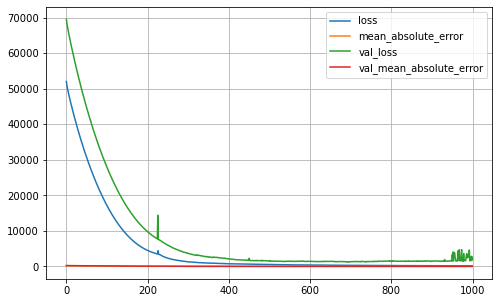

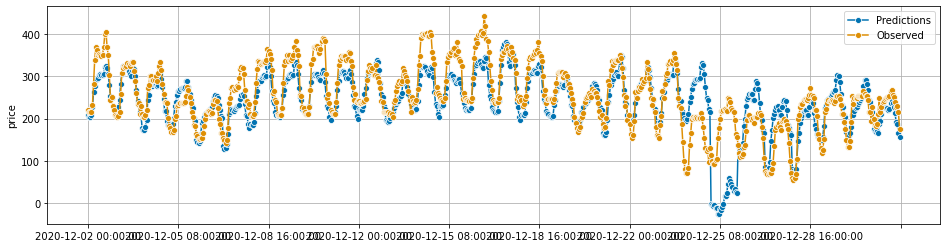

In [60]:
model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(24),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
)


y_valid_pred = pd.Series(model.predict(X_valid_reshaped).flatten())
y_valid_pred.index = y_valid.index

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()

Train on 1059 samples, validate on 30 samples
Epoch 1/1000
1059/1059 [==============================] - 8s 8ms/sample - loss: 51902.3463 - mean_absolute_error: 219.8878 - val_loss: 69377.6719 - val_mean_absolute_error: 252.9291
Epoch 2/1000
1059/1059 [==============================] - 2s 2ms/sample - loss: 51142.8342 - mean_absolute_error: 218.1541 - val_loss: 68613.6172 - val_mean_absolute_error: 251.3694
Epoch 3/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 50528.5117 - mean_absolute_error: 216.7402 - val_loss: 67949.0547 - val_mean_absolute_error: 250.0394
Epoch 4/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 49975.9730 - mean_absolute_error: 215.4595 - val_loss: 67328.2344 - val_mean_absolute_error: 248.7949
Epoch 5/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 49449.0441 - mean_absolute_error: 214.2338 - val_loss: 66728.9609 - val_mean_absolute_error: 247.5884
Epoch 6/1000
1059/1059 [====================

1059/1059 [==============================] - 1s 1ms/sample - loss: 32833.4083 - mean_absolute_error: 171.1785 - val_loss: 47268.3008 - val_mean_absolute_error: 204.6261
Epoch 46/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32486.6972 - mean_absolute_error: 170.1675 - val_loss: 46854.5430 - val_mean_absolute_error: 203.6158
Epoch 47/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 32146.1094 - mean_absolute_error: 169.1686 - val_loss: 46448.9336 - val_mean_absolute_error: 202.6216
Epoch 48/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31806.9105 - mean_absolute_error: 168.1692 - val_loss: 46041.0000 - val_mean_absolute_error: 201.6163
Epoch 49/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31466.5701 - mean_absolute_error: 167.1553 - val_loss: 45632.0859 - val_mean_absolute_error: 200.6037
Epoch 50/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 31130.5006 - mean_

Epoch 90/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19727.0339 - mean_absolute_error: 127.9155 - val_loss: 31219.9629 - val_mean_absolute_error: 161.9815
Epoch 91/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19488.0640 - mean_absolute_error: 127.0084 - val_loss: 30918.9199 - val_mean_absolute_error: 161.0967
Epoch 92/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19252.2630 - mean_absolute_error: 126.1030 - val_loss: 30619.6992 - val_mean_absolute_error: 160.2110
Epoch 93/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 19018.1320 - mean_absolute_error: 125.1965 - val_loss: 30321.8398 - val_mean_absolute_error: 159.3265
Epoch 94/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 18786.3332 - mean_absolute_error: 124.2920 - val_loss: 30025.7910 - val_mean_absolute_error: 158.4429
Epoch 95/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1855

1059/1059 [==============================] - 1s 1ms/sample - loss: 11185.5173 - mean_absolute_error: 90.5591 - val_loss: 20009.4121 - val_mean_absolute_error: 125.7631
Epoch 135/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 11034.9702 - mean_absolute_error: 89.7831 - val_loss: 19800.6562 - val_mean_absolute_error: 125.0083
Epoch 136/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10886.3452 - mean_absolute_error: 89.0218 - val_loss: 19596.4375 - val_mean_absolute_error: 124.2666
Epoch 137/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10739.4457 - mean_absolute_error: 88.2566 - val_loss: 19391.4297 - val_mean_absolute_error: 123.5207
Epoch 138/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10593.0096 - mean_absolute_error: 87.4923 - val_loss: 19186.2422 - val_mean_absolute_error: 122.7707
Epoch 139/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 10449.1868 - mean_

Epoch 179/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 6014.4551 - mean_absolute_error: 60.7185 - val_loss: 12372.4258 - val_mean_absolute_error: 94.9949
Epoch 180/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5934.7227 - mean_absolute_error: 60.2071 - val_loss: 12242.4111 - val_mean_absolute_error: 94.4075
Epoch 181/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5855.5973 - mean_absolute_error: 59.6992 - val_loss: 12111.2607 - val_mean_absolute_error: 93.8106
Epoch 182/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5778.1336 - mean_absolute_error: 59.1991 - val_loss: 11984.9590 - val_mean_absolute_error: 93.2338
Epoch 183/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5701.9468 - mean_absolute_error: 58.7077 - val_loss: 11858.2139 - val_mean_absolute_error: 92.6535
Epoch 184/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 5627.2742 - m

1059/1059 [==============================] - 1s 1ms/sample - loss: 3412.5398 - mean_absolute_error: 42.2840 - val_loss: 7936.4331 - val_mean_absolute_error: 74.4487
Epoch 225/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 3320.8987 - mean_absolute_error: 41.2704 - val_loss: 7857.8350 - val_mean_absolute_error: 73.9331
Epoch 226/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 3269.3907 - mean_absolute_error: 40.7243 - val_loss: 7844.0986 - val_mean_absolute_error: 74.1988
Epoch 227/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 3214.2941 - mean_absolute_error: 40.3824 - val_loss: 7722.6030 - val_mean_absolute_error: 73.4268
Epoch 228/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 3153.2480 - mean_absolute_error: 39.8760 - val_loss: 7678.4448 - val_mean_absolute_error: 73.4073
Epoch 229/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 3092.4351 - mean_absolute_error: 

1059/1059 [==============================] - 1s 1ms/sample - loss: 1800.8980 - mean_absolute_error: 27.1165 - val_loss: 5376.1953 - val_mean_absolute_error: 60.2122
Epoch 270/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1778.0549 - mean_absolute_error: 26.8370 - val_loss: 5341.4121 - val_mean_absolute_error: 60.0718
Epoch 271/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1757.7250 - mean_absolute_error: 26.6675 - val_loss: 5268.2954 - val_mean_absolute_error: 59.4775
Epoch 272/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1737.9673 - mean_absolute_error: 26.4843 - val_loss: 5292.8882 - val_mean_absolute_error: 59.7345
Epoch 273/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1718.6271 - mean_absolute_error: 26.3001 - val_loss: 5286.1895 - val_mean_absolute_error: 59.4673
Epoch 274/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1700.7874 - mean_absolute_error: 

1059/1059 [==============================] - 1s 1ms/sample - loss: 1182.4124 - mean_absolute_error: 21.3806 - val_loss: 3729.5117 - val_mean_absolute_error: 49.8130
Epoch 315/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1175.0485 - mean_absolute_error: 21.3183 - val_loss: 3622.8711 - val_mean_absolute_error: 48.9177
Epoch 316/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1165.0707 - mean_absolute_error: 21.2223 - val_loss: 3672.7952 - val_mean_absolute_error: 49.2979
Epoch 317/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1158.6677 - mean_absolute_error: 21.1778 - val_loss: 3593.8772 - val_mean_absolute_error: 48.9207
Epoch 318/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1151.1711 - mean_absolute_error: 21.1328 - val_loss: 3536.2683 - val_mean_absolute_error: 48.3681
Epoch 319/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 1140.8560 - mean_absolute_error: 

Epoch 360/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 913.6001 - mean_absolute_error: 18.9199 - val_loss: 2644.8079 - val_mean_absolute_error: 41.5782
Epoch 361/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 905.3760 - mean_absolute_error: 18.8479 - val_loss: 2631.7266 - val_mean_absolute_error: 41.2005
Epoch 362/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 893.9245 - mean_absolute_error: 18.6665 - val_loss: 2638.0640 - val_mean_absolute_error: 41.3827
Epoch 363/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 889.0641 - mean_absolute_error: 18.6128 - val_loss: 2572.5603 - val_mean_absolute_error: 40.6915
Epoch 364/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 883.0208 - mean_absolute_error: 18.5357 - val_loss: 2582.0830 - val_mean_absolute_error: 40.8497
Epoch 365/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 878.8802 - mean_absolut

1059/1059 [==============================] - 1s 1ms/sample - loss: 744.8013 - mean_absolute_error: 16.9688 - val_loss: 1933.4596 - val_mean_absolute_error: 35.1081
Epoch 406/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 743.0678 - mean_absolute_error: 16.9873 - val_loss: 1920.1349 - val_mean_absolute_error: 34.8097
Epoch 407/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 744.6379 - mean_absolute_error: 17.0608 - val_loss: 1924.7539 - val_mean_absolute_error: 34.8538
Epoch 408/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 741.3338 - mean_absolute_error: 17.0122 - val_loss: 1932.5104 - val_mean_absolute_error: 34.9232
Epoch 409/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 735.1069 - mean_absolute_error: 16.8816 - val_loss: 1861.5715 - val_mean_absolute_error: 34.4796
Epoch 410/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 732.7159 - mean_absolute_error: 16.860

Epoch 451/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 616.4214 - mean_absolute_error: 15.0428 - val_loss: 1626.9374 - val_mean_absolute_error: 31.7518
Epoch 452/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 618.1151 - mean_absolute_error: 15.1068 - val_loss: 1637.7728 - val_mean_absolute_error: 31.5769
Epoch 453/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 617.5264 - mean_absolute_error: 15.1307 - val_loss: 1633.8965 - val_mean_absolute_error: 31.7599
Epoch 454/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 614.8557 - mean_absolute_error: 15.0642 - val_loss: 1669.2225 - val_mean_absolute_error: 31.8426
Epoch 455/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 609.2710 - mean_absolute_error: 14.9330 - val_loss: 1693.3424 - val_mean_absolute_error: 32.3496
Epoch 456/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 608.1067 - mean_absolut

Epoch 497/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 521.4758 - mean_absolute_error: 13.4034 - val_loss: 1790.0325 - val_mean_absolute_error: 32.1338
Epoch 498/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 519.3038 - mean_absolute_error: 13.3290 - val_loss: 1788.8656 - val_mean_absolute_error: 31.9251
Epoch 499/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 519.5189 - mean_absolute_error: 13.3888 - val_loss: 1823.7966 - val_mean_absolute_error: 32.1238
Epoch 500/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 517.7716 - mean_absolute_error: 13.3576 - val_loss: 1938.3309 - val_mean_absolute_error: 33.6103
Epoch 501/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 519.6716 - mean_absolute_error: 13.4125 - val_loss: 1790.5989 - val_mean_absolute_error: 32.1693
Epoch 502/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 515.7309 - mean_absolut

Epoch 543/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 442.8260 - mean_absolute_error: 12.1824 - val_loss: 1682.7729 - val_mean_absolute_error: 31.4921
Epoch 544/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 440.7861 - mean_absolute_error: 12.1402 - val_loss: 1712.4683 - val_mean_absolute_error: 32.4348
Epoch 545/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 442.3959 - mean_absolute_error: 12.1879 - val_loss: 1756.2618 - val_mean_absolute_error: 32.5266
Epoch 546/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 442.2713 - mean_absolute_error: 12.2176 - val_loss: 1726.2360 - val_mean_absolute_error: 32.0595
Epoch 547/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 438.9937 - mean_absolute_error: 12.1232 - val_loss: 1706.5260 - val_mean_absolute_error: 31.6150
Epoch 548/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 437.6300 - mean_absolut

Epoch 589/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 396.5980 - mean_absolute_error: 11.4604 - val_loss: 1577.6562 - val_mean_absolute_error: 30.4773
Epoch 590/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 394.0910 - mean_absolute_error: 11.4028 - val_loss: 1570.2440 - val_mean_absolute_error: 30.4902
Epoch 591/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 391.3464 - mean_absolute_error: 11.3464 - val_loss: 1556.9938 - val_mean_absolute_error: 30.0612
Epoch 592/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 390.1555 - mean_absolute_error: 11.3103 - val_loss: 1539.6418 - val_mean_absolute_error: 30.1263
Epoch 593/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 389.7312 - mean_absolute_error: 11.2956 - val_loss: 1587.8840 - val_mean_absolute_error: 30.6277
Epoch 594/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 387.5691 - mean_absolut

Epoch 635/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 349.9449 - mean_absolute_error: 10.5663 - val_loss: 1509.6324 - val_mean_absolute_error: 30.5167
Epoch 636/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 350.0555 - mean_absolute_error: 10.5667 - val_loss: 1503.6743 - val_mean_absolute_error: 30.3316
Epoch 637/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 350.5625 - mean_absolute_error: 10.5975 - val_loss: 1510.1351 - val_mean_absolute_error: 30.4305
Epoch 638/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 351.7267 - mean_absolute_error: 10.6754 - val_loss: 1516.7067 - val_mean_absolute_error: 30.1887
Epoch 639/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 350.5831 - mean_absolute_error: 10.6363 - val_loss: 1565.7622 - val_mean_absolute_error: 31.1108
Epoch 640/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 348.3159 - mean_absolut

1059/1059 [==============================] - 1s 1ms/sample - loss: 319.4526 - mean_absolute_error: 10.1377 - val_loss: 1500.4897 - val_mean_absolute_error: 30.5505
Epoch 681/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 317.0065 - mean_absolute_error: 10.0347 - val_loss: 1498.0637 - val_mean_absolute_error: 30.3262
Epoch 682/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 328.0704 - mean_absolute_error: 10.4895 - val_loss: 1495.3445 - val_mean_absolute_error: 30.3771
Epoch 683/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 322.7579 - mean_absolute_error: 10.2785 - val_loss: 1526.1854 - val_mean_absolute_error: 30.6587
Epoch 684/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 317.1218 - mean_absolute_error: 10.1013 - val_loss: 1526.9716 - val_mean_absolute_error: 30.6139
Epoch 685/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 313.5964 - mean_absolute_error: 9.9771

1059/1059 [==============================] - 1s 1ms/sample - loss: 284.5517 - mean_absolute_error: 9.3719 - val_loss: 1495.7815 - val_mean_absolute_error: 30.2563
Epoch 727/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 284.7219 - mean_absolute_error: 9.3794 - val_loss: 1534.6852 - val_mean_absolute_error: 31.0431
Epoch 728/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 284.5777 - mean_absolute_error: 9.4131 - val_loss: 1528.9923 - val_mean_absolute_error: 30.6883
Epoch 729/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 285.4695 - mean_absolute_error: 9.4572 - val_loss: 1536.7560 - val_mean_absolute_error: 30.7795
Epoch 730/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 288.5417 - mean_absolute_error: 9.5582 - val_loss: 1525.3594 - val_mean_absolute_error: 30.5436
Epoch 731/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 287.6295 - mean_absolute_error: 9.5913 - va

1059/1059 [==============================] - 1s 1ms/sample - loss: 258.8014 - mean_absolute_error: 8.8557 - val_loss: 1625.7454 - val_mean_absolute_error: 31.8086
Epoch 773/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 257.0009 - mean_absolute_error: 8.8043 - val_loss: 1654.6597 - val_mean_absolute_error: 32.0682
Epoch 774/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 255.8145 - mean_absolute_error: 8.7513 - val_loss: 1641.1962 - val_mean_absolute_error: 32.0230
Epoch 775/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 254.8940 - mean_absolute_error: 8.7246 - val_loss: 1639.2274 - val_mean_absolute_error: 31.9072
Epoch 776/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 254.2672 - mean_absolute_error: 8.7044 - val_loss: 1646.9454 - val_mean_absolute_error: 32.0834
Epoch 777/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 253.8452 - mean_absolute_error: 8.7029 - va

1059/1059 [==============================] - 1s 1ms/sample - loss: 285.8164 - mean_absolute_error: 10.0364 - val_loss: 1725.6804 - val_mean_absolute_error: 32.7060
Epoch 819/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 275.4161 - mean_absolute_error: 9.7646 - val_loss: 1773.8530 - val_mean_absolute_error: 33.3822
Epoch 820/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 269.1157 - mean_absolute_error: 9.5950 - val_loss: 1744.2615 - val_mean_absolute_error: 33.0138
Epoch 821/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 265.4491 - mean_absolute_error: 9.5053 - val_loss: 1772.0513 - val_mean_absolute_error: 33.3289
Epoch 822/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 261.8993 - mean_absolute_error: 9.3886 - val_loss: 1723.7625 - val_mean_absolute_error: 32.8225
Epoch 823/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 259.0621 - mean_absolute_error: 9.2894 - v

Epoch 864/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 223.3394 - mean_absolute_error: 8.2250 - val_loss: 1695.1029 - val_mean_absolute_error: 32.2578
Epoch 865/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 222.7149 - mean_absolute_error: 8.2124 - val_loss: 1687.5266 - val_mean_absolute_error: 32.1926
Epoch 866/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 222.0836 - mean_absolute_error: 8.2047 - val_loss: 1703.8010 - val_mean_absolute_error: 32.3891
Epoch 867/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 221.6222 - mean_absolute_error: 8.1869 - val_loss: 1700.1562 - val_mean_absolute_error: 32.3263
Epoch 868/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 221.0960 - mean_absolute_error: 8.1735 - val_loss: 1720.4667 - val_mean_absolute_error: 32.5770
Epoch 869/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 220.5452 - mean_absolute_err

1059/1059 [==============================] - 1s 1ms/sample - loss: 204.4395 - mean_absolute_error: 7.8238 - val_loss: 1771.3635 - val_mean_absolute_error: 32.9335
Epoch 911/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 204.1652 - mean_absolute_error: 7.7970 - val_loss: 1766.8562 - val_mean_absolute_error: 32.7370
Epoch 912/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 204.0762 - mean_absolute_error: 7.8091 - val_loss: 1756.1062 - val_mean_absolute_error: 32.6773
Epoch 913/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 204.0450 - mean_absolute_error: 7.8144 - val_loss: 1785.6404 - val_mean_absolute_error: 32.9822
Epoch 914/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 203.6305 - mean_absolute_error: 7.7978 - val_loss: 1773.3705 - val_mean_absolute_error: 32.8109
Epoch 915/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 203.1054 - mean_absolute_error: 7.7959 - va

1059/1059 [==============================] - 1s 1ms/sample - loss: 189.6796 - mean_absolute_error: 7.4871 - val_loss: 1839.1594 - val_mean_absolute_error: 33.5971
Epoch 956/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 189.9936 - mean_absolute_error: 7.4882 - val_loss: 1807.8607 - val_mean_absolute_error: 33.1918
Epoch 957/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 190.1928 - mean_absolute_error: 7.5196 - val_loss: 1860.9263 - val_mean_absolute_error: 33.7783
Epoch 958/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 189.2370 - mean_absolute_error: 7.5011 - val_loss: 1832.5503 - val_mean_absolute_error: 33.4605
Epoch 959/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 188.4802 - mean_absolute_error: 7.4516 - val_loss: 1843.9840 - val_mean_absolute_error: 33.5863
Epoch 960/1000
1059/1059 [==============================] - 1s 1ms/sample - loss: 188.9059 - mean_absolute_error: 7.4787 - va

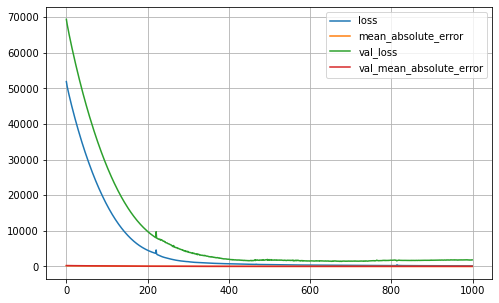

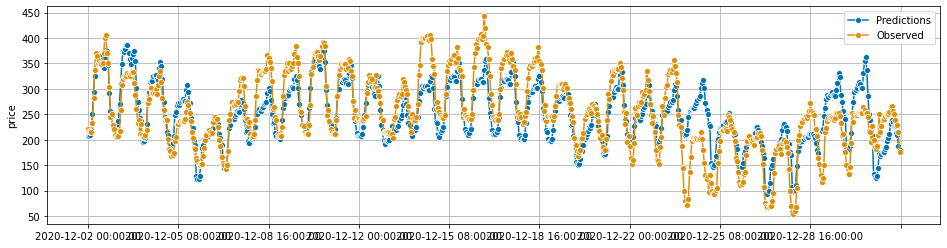

In [61]:
model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(24),
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])
history = model.fit(
    X_train_reshaped, 
    y_train_reshaped, 
    epochs=1000, 
    validation_data=(X_valid_reshaped, y_valid_reshaped),
)


y_valid_pred = pd.Series(model.predict(X_valid_reshaped).flatten())
y_valid_pred.index = y_valid.index
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plot_series(y_valid_pred, y_valid, labels=['Predictions', 'Observed'])
plt.grid()

Validation error: 42.953794854667585, Benchmark error: 34.117237015574034


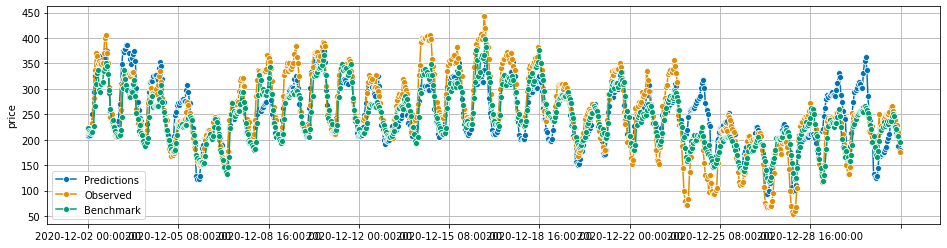

In [80]:
y_pred_external = pd.Series(external_predictions.loc[y_valid.index,:].iloc[:,0])
valid_error = np.sqrt(mean_squared_error(y_pred=y_valid_pred, y_true=y_valid))
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

print(f'Validation error: {valid_error}, Benchmark error: {benchmark_valid_error}')

plot_series(y_valid_pred, y_valid, y_pred_external, labels=['Predictions', 'Observed', 'Benchmark'])
plt.grid()